# COVID19 Risk Score Tuner V2.0

Kevin Murphy (kpmurphy@google.com), Stelios Serghiou (serghiou@google.com), Adam Pearce (adampearce@google.com)

Last update: 9 October 2020

This Colab computes the probability of COVID transmission from a transmitter to a receiver, as a function of distance (estimated from bluetooth attenuation), duration, and infectiousness of the transmitter (estimated based on days since symtom onset), using a [standard exponential dose response model](http://qmrawiki.canr.msu.edu/index.php/Dose_response_assessment). The parameters of this model are derived from recent papers on the epidemiology of COVID, and on empirical bluetooth attenuation data (details below). 

In addition, the Colab computes the risk score, as defined by the [Google/ Apple Exposure Notification System](https://en.wikipedia.org/wiki/Exposure_Notification). This risk score approximates the probability of COVID transmission between two people. The score has [various parameters](https://enconfig.storage.googleapis.com/enconfig_fixed.html) that need to be set by the public health authority. This Colab lets the user visualize the effect of changing these parameters, as compared to the above model. 


In [ ]:
import itertools
from dataclasses import dataclass
import collections
from collections import namedtuple

import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib.cm as cm 

import sklearn
from sklearn import metrics



# Model

The probability of transmitting the virus from transmitter to receiver is given by a [standard exponential dose response model](http://qmrawiki.canr.msu.edu/index.php/Dose_response_assessment).

$$
\begin{align}
p(y=1|x) &= 1-e^{-\beta \; h(x)} \\
h(x) &= t \times f_{\text{dist}}(d)
\times f_{\text{inf}}(\Delta)
\end{align}
$$

where $x=(t,d,\Delta)$ is the exposure defined in terms of duration $t$, distance $d$ and days since symptom onset $\Delta$, and $h(x)$ is the hazard function, which computes the viral dose that is received.

We define $f_{\text{dist}}(d)$ and $f_{\text{inf}}(\Delta)$ below.
We also explain how to infer distance from bluetooh attenuation.

We set $\beta$ by hand, so that $p(y=1|x)=0.3$ when $t=8$ hours, $d=2$ m, and $\Delta=0$, to match the empirical attack rate in Wilson (2020).

The probability that the receiver gets infected is equal to the susceptibility times the probability of transmission. Susceptbility depends on many factors, such as the age of the receiver, whether they are wearing a mask, etc. We do not model this, since it is not part of the GAEN system.

* [Quantifying SARS-CoV-2-infection risk withing the Apple/Google exposure notification framework to inform quarantine recommendations](https://www.medrxiv.org/content/10.1101/2020.07.17.20156539v1), Amanda Wilson, Nathan Aviles,  Paloma  Beamer, Zsombor Szabo, Kacey  Ernst, Joanna Masel. July 2020.
[Code](https://github.com/awilson12/risk_scoring).



## Viral transmission vs distance

### Spline model

Wilson use a physical simulator of short-range aerosol spread. We [modified their Monte Carlo simulation code](https://github.com/probml/covid19/blob/master/WilsonMasel/distance_dose_figure_v2_stelios.R) to generate risk at different distances. We fit a cubic spline to this data (see code below). Thus we get the following non-parametric model.

$$
f_{\text{dist}}(d) =  \text{SplineInterpolate}(d; \text{SimData})
$$



* [Quantifying SARS-CoV-2-infection risk withing the Apple/Google exposure notification framework to inform quarantine recommendations](https://www.medrxiv.org/content/10.1101/2020.07.17.20156539v1), Amanda Wilson, Nathan Aviles,  Paloma  Beamer, Zsombor Szabo, Kacey  Ernst, Joanna Masel. July 2020.


In [ ]:
from scipy.interpolate import splev, splrep
import pandas as pd

def spline_fit():
  url = "https://raw.githubusercontent.com/probml/covid19/master/arizona-covid-droplet-sim/stelios-dose-data-scaled.csv"
  df = pd.read_csv(url)
  distances = df['distance'].to_numpy()
  doses = df['dose'].to_numpy()
  ndx1 = (distances <= 1)
  ndx2 = (distances > 1)
  x = distances[ndx1]
  y = doses[ndx1]
  spline1 = splrep(x, y) # (t, c, k), contains knots, coefficients, degree
  x = distances[ndx2]
  y = doses[ndx2]
  spline2 = splrep(x, y)
  return spline1, spline2

spline1, spline2 = spline_fit() # pre-compute fit
def transmission_vs_distance_spline(x, foo=42):
  if np.isscalar(x):
    x = np.array([x])
    scalar = True
  else:
    scalar = False
  n = len(x)
  ndx = np.where(x <= 1)
  y1 = splev(x, spline1)
  y2 = splev(x, spline2)
  y = np.zeros(n)
  y[x <= 1] = y1[x <= 1]
  y[x > 1] = y2[x > 1]
  if scalar:
    y = y[0]
  max_val = 60359.04 # transmission_vs_distance_spline(0)
  y = y/max_val # scale so that max value is 1.0
  return y


In [ ]:
def plot_transmission_fun(fun, ax, *args, **kwargs):
  use_log = kwargs.get('use_log', False)
  ttl = kwargs.get('title', None)
  x = np.linspace(0, 5, 100)
  y = fun(x, *args)
  ax.plot(x, y)
  ax.set_xlabel('distance (meters)')
  ax.set_ylabel('distance factor')
  if ttl:
    ax.set_title(ttl)
  if use_log:
    ax.set_yscale('log')

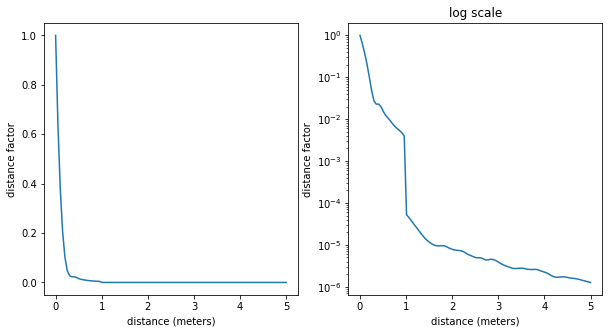

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
plot_transmission_fun(transmission_vs_distance_spline, axs[0],  use_log=False)
plot_transmission_fun(transmission_vs_distance_spline, axs[1],  use_log=True, title='log scale')


### Quadratic model


Briers (2020) propose the following quadratic model 
$$
f_{\text{dist}}(d) =  \min(1, D^2_{\min}/d^2)
 $$

They set
$D^2_{\min}=1$  based on argument of the physics of droplet spread.
However, we make this parameter adjustable, to capture the possibility of longer-range aerosal tranmissions.

* [Risk scoring in contact tracing apps](unpublished), Mark Briers, Marcos Charalambides, Christophe Fraser, Chris Holmes, Radka Jersakova, James Lomax, and Tom Lovett. 26 July 2020

In [ ]:
def transmission_vs_distance_quadratic(d, Dmin=1):
  eps = 1e-10
  m = np.power(Dmin,2)/(np.power(d, 2)+eps)
  return np.minimum(1, m)


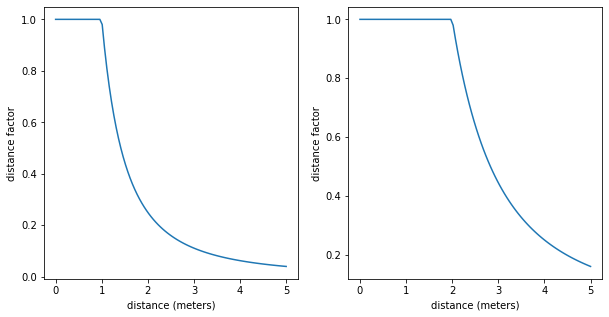

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(5*2,5))
plot_transmission_fun(transmission_vs_distance_quadratic, axs[0], 1)
plot_transmission_fun(transmission_vs_distance_quadratic, axs[1], 2)

### Sigmoid model

Cencetti propose the following sigmoidal decay function to encode the risk at different distances:


$$
f_{\text{dist}}(d) = 1-\frac{1}{1+\exp(-a d + b)}
 $$

They heuristically set $a = 1.5$ and $b=6.6$ so that the factor is $\approx 1$ for $d < 2$, $0.5$ at $d=4.4$ and $\approx 0$ for $d \geq 10$ (where $d$ is in meters).


* [Digital Proximity Tracing in the COVID-19 Pandemic on Empirical Contact Networks](https://www.medrxiv.org/content/10.1101/2020.05.29.20115915v2)
Giulia Cencetti et al., June 2020. [Code](https://github.com/DigitalContactTracing/covid_code)

To make these parameters more intuitive, and easier to adjust, we reparameterize the model in terms of its slope $w$, and its inflection point
$c$, which is where the curve crosses 0.5:

$$
f_{\text{dist}}(d) = 1-\frac{1}{1+\exp(-w d + w c)}
 $$



In [ ]:
def transmission_vs_distance_sigmoid(distance, slope=2, inflection=2):
  return 1-1/(1+np.exp(-slope*distance + slope*inflection))

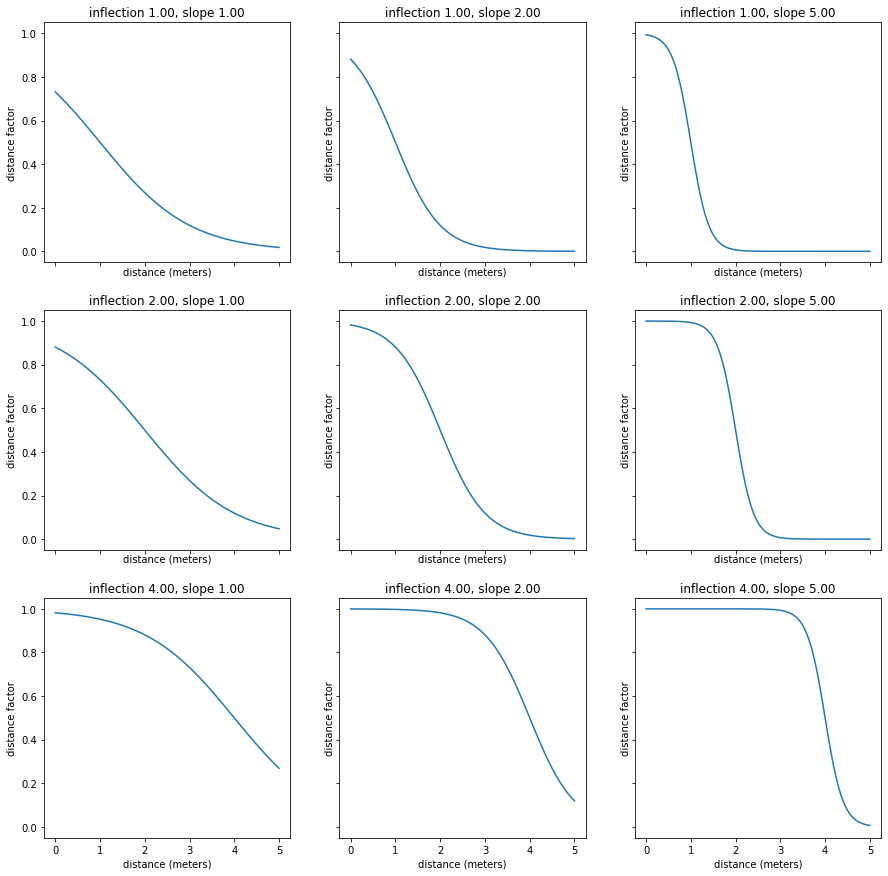

In [ ]:
inflections = [1,2,4]
slopes = [1,2,5]
m = len(inflections)
n = len(slopes)
fig, axs = plt.subplots(m,n, figsize=(5*n,5*m), sharex=True, sharey=True)
#axs = np.reshape(axs, (n,))
for i in range(m):
  inflection = inflections[i]
  for j in range(n):
    ax = axs[i,j]
    slope = slopes[j]
    ttl = 'inflection {:0.2f}, slope {:0.2f}'.format(inflection, slope)
    plot_transmission_fun(transmission_vs_distance_sigmoid, ax, slope, inflection, title=ttl)

### Comparison

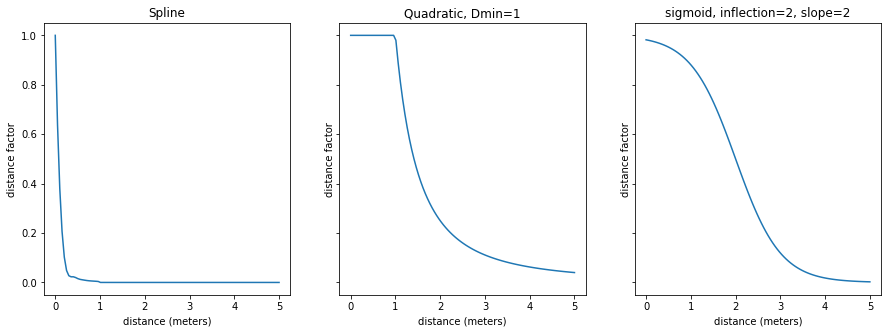

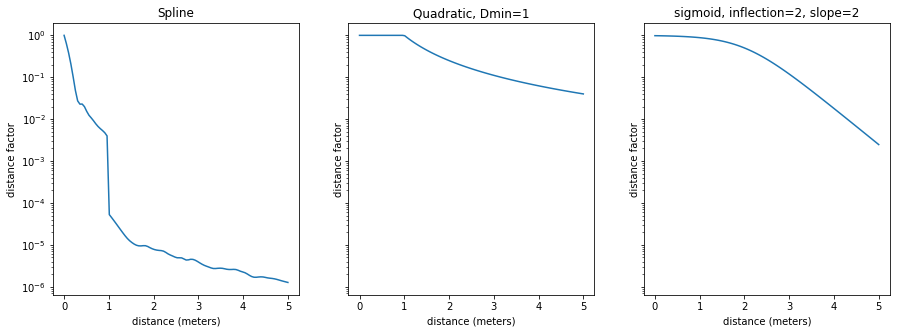

In [ ]:

log_scales = [False, True]
for log_scale in log_scales:  
  fig, axs = plt.subplots(1,3, figsize=(5*3,5), sharex=True, sharey=True)

  ttl = 'Spline'
  plot_transmission_fun(transmission_vs_distance_spline, axs[0], title=ttl, use_log=log_scale)

  ttl = 'Quadratic, Dmin=1'
  plot_transmission_fun(transmission_vs_distance_quadratic, axs[1], Dmin=1,  title=ttl, use_log=log_scale)

  ttl = 'sigmoid, inflection=2, slope=2'
  plot_transmission_fun(transmission_vs_distance_sigmoid, axs[2], slope=2, inflection=2, title=ttl,  use_log=log_scale)



## Infectiousness vs TOST





Suppose Bob gets infected and shows symptoms at time $T^s$.
Then Bob meets Alice, who gets exposed at time $T^e$.
Let $\Delta=T^e - T^s$ be time since onset of symptoms to transmission (TOST).
Let $f_{\rm{inf}}(\Delta)$ be the infectiousness as a function of TOST.  (This is positive for symptomatic transmission, and negative for pre-symptomatic transmission.)
To model $f_{\rm{inf}}$, we use one of the models proposed in  Ferretti'20 (see supplementary Table 4). (The best fitting models are the Student T and the skew logistic distributions.)


* [The timing of COVID-19 transmission](https://www.medrxiv.org/content/10.1101/2020.09.04.20188516v1.abstract), Luca Ferretti et al, Sept. 2020


In [ ]:
def infectiousness_skew_logistic(tost):
  ps = scipy.stats.genlogistic.pdf(tost, 1.1248, loc=-0.2657, scale=1.5235)
  pmax = scipy.stats.genlogistic.pdf(0, 1.1248, loc=-0.2657, scale=1.5235)
  return ps/pmax

def infectiousness_student(tost):
  ps = scipy.stats.t.pdf(tost, 3.3454, loc=-0.0747, scale=1.8567)
  pmax = scipy.stats.t.pdf(0, 3.3454, loc=-0.0747, scale=1.8567)
  return ps/pmax

def infectiousness_gaussian(tost):
  ps = scipy.stats.norm.pdf(tost, loc=0.0486, scale=2.7315)
  pmax = scipy.stats.norm.pdf(0, loc=0.0486, scale=2.7315)
  return ps/pmax

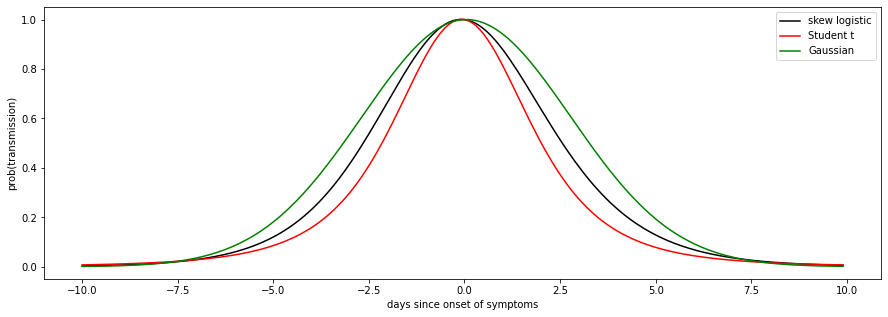

In [ ]:

plt.figure(figsize=(15,5))
tost = np.arange(-10, 10, 0.1)
ps =  infectiousness_skew_logistic(tost)
plt.plot(tost, ps, label='skew logistic', color='k')

ps =  infectiousness_student(tost)
plt.plot(tost, ps, label='Student t', color='r')

ps = infectiousness_gaussian(tost)
plt.plot(tost, ps, label='Gaussian', color='g')

plt.xlabel('days since onset of symptoms')
plt.ylabel('prob(transmission)')
plt.legend()

## Bluetooth simulator




We use the discriminative log-normal regression model from Figure 4 of the Lovett paper,
which was fit to [H0H1 data from MIT Lincoln Labs](https://github.com/mitll/H0H1). 


* [Inferring proximity from Bluetooth Low Energy RSSI with Unscented Kalman Smoothers](https://arxiv.org/abs/2007.05057), Tom Lovett, Mark Briers, Marcos Charalambides, Radka Jersakova, James Lomax, Chris Holmes, July 2020.


We assume
$$
\begin{align}
R(d) &= \text{RSSI} \\
A(d) &= \text{attenuation} = t_x - r_x - R(d)  \\
\log(-R(d)) &\sim N(\mu(d),\sigma) \\
\mu(d) &= w \log(d) + b
\end{align}
$$
 where 
$w=0.21$,  $b=3.92$, $\sigma^2=0.33$,
$t_x$ is the transmitter strength, $r_x$ is the receiver strength, (aka correction factor), and $t_x - r_x = 2.398$.

To compute the expected distance $d$ from attenuation $A$, we first compute $R$ from $A$, and then invert the equation for the mean:
$$
\begin{align}
\log(-R) &= w \log(d) + b \\
d &= \exp( (\log(-R) - b)/w ) 
\end{align}
$$

In [ ]:
@dataclass
class BleParams:
  slope: float = 0.21
  intercept: float = 3.92
  tx: float = 0.0
  correction: float=2.398
  name: str = 'briers-lognormal'

def atten_to_dist(atten, params=BleParams()):
  rssi = params.tx  - (atten + params.correction)
  return np.exp((np.log(-rssi) - params.intercept)/params.slope)

def dist_to_atten(distance, params=BleParams()):
  mu = params.intercept + params.slope * np.log(distance)
  rssi = -np.exp(mu)
  atten = params.tx  - (rssi + params.correction)
  return atten

def dist_to_atten_sample(distances, params=BleParams(), sigma=np.sqrt(0.33)):
    if sigma == 0:
      return dist_to_atten(distances, params)
    N = len(distances)
    mus = params.intercept + params.slope * np.log(distances)
    sigs = sigma
    rssi = -scipy.stats.lognorm(s=sigs, scale=np.exp(mus)).rvs()
    atten = params.tx  - (rssi + params.correction)
    return atten

In [ ]:
dist = 2
atten = dist_to_atten(dist)
print(atten) # the "magic" threshold

55.899598938359304


In [ ]:
def plot_ble_curves(sigma_list):
  distances  = np.arange(1, 5, 0.01)
  ble_params = BleParams()
  n = len(sigma_list)
  fig, axs = plt.subplots(1,n, figsize=(5*n,5), sharex=True, sharey=False)
  axs = np.reshape(axs, (n,))
  for i, sigma in enumerate(sigma_list):
    mu = dist_to_atten(distances, ble_params)
    np.random.seed(0)
    attens = dist_to_atten_sample(distances, ble_params, sigma)
    ax = axs[i]
    ax.plot(distances, attens, '.')
    ax.plot(distances, mu, 'k-', lw=5)
    ax.set_ylabel('attenuation (dB)')
    ax.set_xlabel('distance (m)')
    ax.set_title('sigma={:0.3f}'.format(sigma))
    ax.set_ylim(40,100)

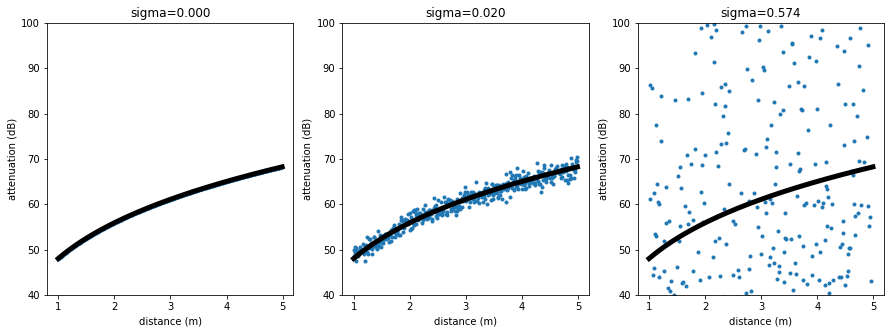

In [ ]:
sigma_list = [0, 0.02, np.sqrt(0.33)]
plot_ble_curves(sigma_list)

If we have a sequence of measurements, we can use signal processing techniques to try to reduce the noise. In the Lovett paper, they use an approach based on Kalman filtering. However, if we don't care about posterior uncertainty, and just want a point estimate, we can use simpler methods, like median filtering. We demonstrate this below. 


* [Inferring proximity from Bluetooth Low Energy RSSI with Unscented Kalman Smoothers](https://arxiv.org/abs/2007.05057), Tom Lovett, Mark Briers, Marcos Charalambides, Radka Jersakova, James Lomax, Chris Holmes, July 2020.




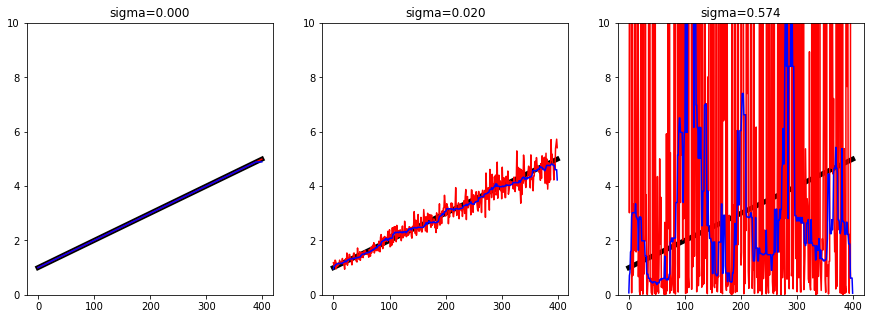

In [ ]:

import scipy.signal

distance_true  = np.arange(1, 5, 0.01)
ble_params = BleParams()
sigma_list = [0, 0.02, np.sqrt(0.33)]
n = len(sigma_list)
fig, axs = plt.subplots(1,n, figsize=(5*n,5))
axs = np.reshape(axs, (n,))

for i, sigma in enumerate(sigma_list):
  np.random.seed(0)
  attens = dist_to_atten_sample(distance_true, ble_params, sigma)
  distance_naive = atten_to_dist(attens, ble_params)
  distance_medfilt = scipy.signal.medfilt(distance_naive, kernel_size=21) 
  ax = axs[i]
  ax.plot(distance_true, 'k', lw=5)
  ax.plot(distance_naive, 'r')
  ax.plot(distance_medfilt, 'b')
  ax.set_ylim(0,10)
  ax.set_title('sigma={:0.3f}'.format(sigma))

## Probability of infection

Let $y=1$ iff the person receives a viral dose which is sufficiently high to cause infection, assuming 100% susceptibilty. We assume the probability of this event is as follows:

$$
\begin{align}
p(y=1|x) &= 1-e^{-\beta \; h(x)} \\
h(x) &= t \times f_{\text{dist}}(d)
\times f_{\text{inf}}(\Delta)
\end{align}
$$

where al the terms are defined above.


In [ ]:


@dataclass
class ModelParams:
  ble_params: BleParams = BleParams() 
  distance_fun: str = 'quadratic' # quadratic  or sigmoid
  distance_Dmin: float = 1.0
  distance_slope: float = 2.0
  distance_inflection: float = 2.0
  infectiousness_fun: str = 'student' # student, gaussian or skew-logistic
  beta: float = 0.8*1e-3 # transmission rate to approximately match Wilson (2020) paper

def hazard_fun_batch(attenuations, durations, symptom_days, params, distances=None):
  if distances is None:
    distances = atten_to_dist(attenuations, params.ble_params)

  if params.distance_fun == 'quadratic':
    fd = transmission_vs_distance_quadratic(distances, params.distance_Dmin)
  elif params.distance_fun == 'sigmoid':
    fd = transmission_vs_distance_sigmoid(distances, params.distance_slope, params.distance_inflection)
  elif params.distance_fun == 'spline':
    fd = transmission_vs_distance_spline(distances)

  if params.infectiousness_fun == 'gaussian':
    finf = infectiousness_gaussian(symptom_days) 
  elif params.infectiousness_fun == 'skew-logistic':
    finf = infectiousness_skew_logistic(symptom_days)
  elif params.infectiousness_fun == 'student':
    finf = infectiousness_student(symptom_days)

  doses  = durations * fd * finf 
  return doses

def prob_infection_batch(attenuations, durations, symptom_days, params, distances=None):
  doses = hazard_fun_batch(attenuations, durations, symptom_days, params, distances)
  return 1-np.exp(-params.beta * doses)

params = ModelParams()
print(params)



ModelParams(ble_params=BleParams(slope=0.21, intercept=3.92, tx=0.0, correction=2.398, name='briers-lognormal'), distance_fun='quadratic', distance_Dmin=1.0, distance_slope=2.0, distance_inflection=2.0, infectiousness_fun='student', beta=0.0008)


In [ ]:
distance = 1 # very close
duration = 8*60
onset = 0
atten = dist_to_atten(distance)
pinfection = prob_infection_batch(atten, duration, onset, params)
print(pinfection) # should be close to 30%, according to Wilson
assert np.allclose(pinfection, 0.3, atol=1e-1)

0.3188685727942975


In [ ]:
distance = 1 # very close
duration = 15
onset = 0
atten = dist_to_atten(distance)
pinfection = prob_infection_batch(atten, duration, onset, params)
print(pinfection) 


0.011928287136883764


## ENS risk score 

Consider a single exposure event $x=(t, a, \Delta)$, where $t$ is the duration (in minutes), $a$ is the attenuation, and $\Delta$ is the days since symptom onset.
Let $b(a)$ be the bucket into which the attenuation falls (based on the specified thresholds $\theta$), and let $i(\Delta)$ be the infectiousness level (based on the sympton onset mapping $\Psi$). The GAEN API defines the risk  in terms of effective exposure minutes, as follows:

$$
r(x; w,\theta,\Psi) = t \times w_b^{\text{atten}} \times w_i^{\text{inf}}
$$

The parameters $w$, $\theta$ and $\psi$ are specified by the configuration file provided by the PHA (see below).

We can convert this to a probability of infection using

$$
q(y=1|x) = 1-e^{-\beta \; r(x)}
$$
Thus we interpret the risk score as an approximation to the dose (hazard) function. Following Wilson, we set $\beta=3.1 \times 10^{-6}$, which gives a probability of infection after 8h of exposure to a maximally infectious person at the minimal attenuation bucket of 0.3, which matches the empirical attack rate for at-home exposures.

* [Quantifying SARS-CoV-2-infection risk withing the Apple/Google exposure notification framework to inform quarantine recommendations](https://www.medrxiv.org/content/10.1101/2020.07.17.20156539v1), Amanda Wilson, Nathan Aviles,  Paloma  Beamer, Zsombor Szabo, Kacey  Ernst, Joanna Masel. July 2020

In [ ]:

@dataclass
class RiskConfig:
    ble_thresholds: np.array  = np.array([])
    ble_weights: np.array  = np.array([])
    inf_levels: np.array  = np.array([])
    inf_weights: np.array  = np.array([])
    name: str = ''
    beta: float = 3.1  * 1e-4 # Wilson table 1 (divide by 100)

def get_one_hot(targets, num_classes):
  # https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy
  I = np.eye(num_classes)
  r = np.atleast_1d(targets)
  res = I[r]
  s = list(r.shape) + [num_classes]
  return res.reshape(s)


def infectiousness_score_batch(symptom_days, inf_levels, inf_weights): 
  # Map each symptom onset day to a level, and return the correspond weights.
  # symptom_days is an array of ints in -14..14
  symptom_days = np.atleast_1d(symptom_days)
  inf_labels = inf_levels[symptom_days + 14]
  inf_vecs = get_one_hot(inf_labels, num_classes = len(inf_weights))
  tmp = np.multiply(inf_weights, inf_vecs)
  scores = np.sum(tmp, 1)
  return scores

def attenuation_score_batch(attenuations, thresholds, weights):
  # Map each attenuation to the corresponding bucket
  # and return the corresponding set of weights.
  attenuations = np.atleast_1d(attenuations)
  labels = np.digitize(attenuations, thresholds)
  vecs = get_one_hot(labels, num_classes = len(weights))
  tmp = np.multiply(weights, vecs)
  scores = np.sum(tmp, 1)

  scores2 = np.matmul(vecs, weights)
  assert np.allclose(scores, scores2)
  return scores

def risk_score_batch(attenuations, durations, symptom_days, config):
  attenuations = np.atleast_1d(attenuations)
  durations = np.atleast_1d(durations)
  symptom_days = np.atleast_1d(symptom_days)
  winf = infectiousness_score_batch(symptom_days, config.inf_levels, config.inf_weights)
  watten = attenuation_score_batch(attenuations, config.ble_thresholds, config.ble_weights)
  risks = durations * watten * winf
  return risks

def prob_risk_score_batch(attenuations, durations, symptom_days, config):
  risks = risk_score_batch(attenuations, durations, symptom_days, config)
  probs = 1-np.exp(-config.beta * risks)
  return probs

# Specify risk configurations

## Attenuation thresholds

In [ ]:
# Thresholds and weights for v1 of the API
ble_swiss = RiskConfig(ble_thresholds = np.array([53, 60]),
                          ble_weights = np.array([1.0, 0.5, 0.0]),
                          name= 'Switzerland')

ble_germany = RiskConfig(ble_thresholds = np.array([55, 63]),
                            ble_weights = np.array([1.0, 0.5, 0.0]),
                            name= 'Germany')

ble_ireland = RiskConfig(ble_thresholds = np.array([56, 62]),
                            ble_weights = np.array([1.0, 1.0, 0.0]),
                            name= 'Ireland')

ble_arizona = RiskConfig(ble_thresholds = np.array([50, 70]),
                           ble_weights = np.array([2.39, 0.6, 0.06]),
                           name = 'Arizona')

def make_ble_params_v1():
  # Arizona parameters
  # We scale up by 100 to make them percentages, to be comparable to other PHAs
  thresholds = np.array([50, 70])
  weights = np.array([2.39, 0.6, 0.06])
  return thresholds, weights

def make_ble_params_v2():
  # Extrapolated from Arizona parameters
  thresholds = np.array([50, 70, 80])
  weights = np.array([2.39, 0.6, 0.06, 0.01])
  return thresholds, weights

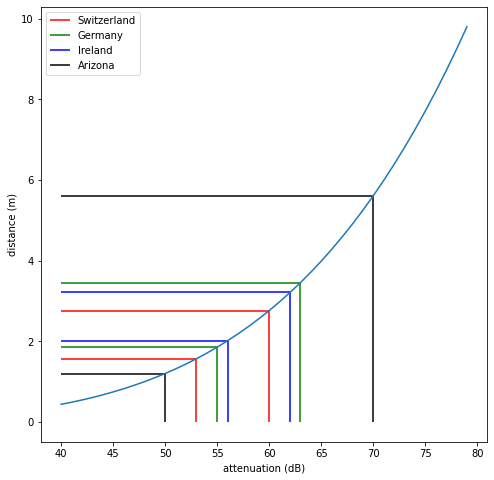

In [ ]:
ble_list = [ble_swiss, ble_germany, ble_ireland, ble_arizona]

attens = np.arange(40, 80)
ble_params = BleParams()
distances = atten_to_dist(attens, ble_params)

fig, axs = plt.subplots(1,1, figsize=(8,8))
axs = np.reshape(axs, (1,))
ax = axs[0]
ax.plot(attens, distances)
ax.set_xlabel('attenuation (dB)')
ax.set_ylabel('distance (m)')
                
names = [config.name for config in ble_list]
colors = ['r', 'g', 'b', 'k']
handles = []
for i, config in enumerate(ble_list):
    for j, thresh in enumerate(config.ble_thresholds):
      dist =  atten_to_dist(thresh, ble_params)
      handle = ax.vlines(thresh, 0, dist, color=colors[i])
      ax.hlines(dist, np.min(attens), thresh, color=colors[i])
      if j==0:
        handles.append(handle)
ax.legend(handles, names)
plt.show()

## Infectiousness levels



Below we map the days since sympton onset to an infectiousness level.
We consider two versions of this. For the v1 API, we use the parameters from Wilson's paper, which uses 6 levels. For the v2 API, we simplify the Wilson parameters down to 2 levels.


* [Quantifying SARS-CoV-2-infection risk withing the Apple/Google exposure notification framework to inform quarantine recommendations](https://www.medrxiv.org/content/10.1101/2020.07.17.20156539v1), Amanda Wilson, Nathan Aviles,  Paloma  Beamer, Zsombor Szabo, Kacey  Ernst, Joanna Masel. July 2020

Figure below from this paper are settings for v1 of Arizona's [CovidWatch app](https://www.covidwatch.org/).


<img src="https://github.com/probml/covid19/blob/master/Figures/infectiousness-TOST-MaselFig5A.png?raw=true">


In [ ]:
def make_infectiousness_params_v1():
  # Arizona settings
  inf_pre = np.zeros((9), dtype=int)
  inf_post = np.zeros((5), dtype=int)
  inf_mid = np.array([1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2, 1, 1])
  inf_levels = np.concatenate((inf_pre, inf_mid, inf_post))
  inf_weights = np.array([0, 10**1, 10**1.2, 10**1.4, 10**1.6, 10**1.8, 10**2])/100
  return inf_levels, inf_weights

def make_infectiousness_params_v2():
  # Derived from Arizona by averaging some bins
  inf_pre = np.zeros((9), dtype=int)
  inf_post = np.zeros((5), dtype=int)
  inf_mid6 = np.array([1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2, 1, 1])
  inf_mid = np.ones_like(inf_mid6)
  ndx = (inf_mid6 >= 5)
  inf_mid[ndx] = 2
  #inf_mid = np.array([1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1])
  inf_levels = np.concatenate((inf_pre, inf_mid, inf_post))
  inf_weights = np.array([0,  10**1.6, 10**2])/100
  return inf_levels, inf_weights

def make_infectiousness_params_v0():
  # Currently PHAs ignore exposures with sympton onset earlier than -2 days.
  # Apart from that, they treat all infectiousness levels equally.
  n = 29 # -14..14 is 29, -14..-3 is 12
  levels = [0] * 12 + [1] * (n-12) 
  levels = np.array(levels)
  weights = np.array([0,1,1]) # drop, standard, high
  return levels, weights



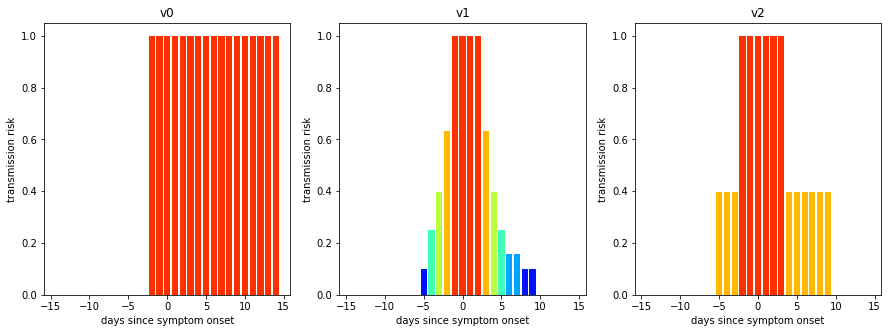

In [ ]:
import matplotlib.cm as cm 
cmap = cm.get_cmap('jet')
ts = np.arange(-14, 14+1, 1)
levels0, weights0 = make_infectiousness_params_v0()
levels1, weights1 = make_infectiousness_params_v1()
levels2, weights2 = make_infectiousness_params_v2()

name_list = ['v0', 'v1', 'v2']
level_list = [levels0, levels1, levels2]
weight_list = [weights0, weights1, weights2]

n = len(level_list)
fig, axs = plt.subplots(1,n, figsize=(5*n,5))
axs = np.reshape(axs, (n,))

for i in range(n):
  levels = level_list[i]  
  weights = weight_list[i]
  name = name_list[i]
  ps = infectiousness_score_batch(ts, levels, weights) 
  nlevels = len(np.unique(levels))
  # match color scheme for 6 levels
  if nlevels==2: 
    palette = [cmap(0/7), cmap(6/7)]
    colors = [palette[c] for c in levels]
  elif nlevels==3: # match color scheme for 6 levels
    palette = [cmap(0/7), cmap(5/7), cmap(6/7)]
    colors = [palette[c] for c in levels]
  else:
    colors = [cmap(c/nlevels) for c in levels]    
  ax = axs[i]                                         
  ax.bar(ts, ps, color = colors)
  ax.set_xlabel('days since symptom onset');
  ax.set_ylabel('transmission risk');
  ax.set_title(name)



In [ ]:
levels, weights = make_infectiousness_params_v1()
levels = np.unique(levels)
nlevels = len(levels)
print(levels)
print(nlevels)
colors = [cmap(c/nlevels) for c in levels]
for c in colors:
  print(c)

colors = [(0.0, 0.0, 0.5, 1.0), (1.0, 0.7269426289034134, 0.0, 1.0), (1.0, 0.18954248366013093, 0.0, 1.0)]

[0 1 2 3 4 5 6]
7
(0.0, 0.0, 0.5, 1.0)
(0.0, 0.06470588235294118, 1.0, 1.0)
(0.0, 0.6450980392156863, 1.0, 1.0)
(0.24984187223276405, 1.0, 0.717900063251107, 1.0)
(0.7179000632511068, 1.0, 0.2498418722327641, 1.0)
(1.0, 0.7269426289034134, 0.0, 1.0)
(1.0, 0.18954248366013093, 0.0, 1.0)


## Published configurations

In [ ]:
# Published configs are just for v1 of the API

# Currently most PHAs ignore exposures with sympton onset earlier than -2 days.
# Apart from that, they treat all infectiousness levels equally.
inf_levels_drop = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,    1,    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int)
assert len(inf_levels_drop)==len(np.arange(-14,14+0.1))
inf_weights_unif = np.array([0, 100, 100])/100 # drop, standard, high

config_swiss = RiskConfig(ble_thresholds = np.array([55, 63]),
                          ble_weights = np.array([100, 50, 0])/100,
                          inf_levels = inf_levels_drop,
                          inf_weights = inf_weights_unif,
                          name= 'Switzerland')

print(config_swiss)

config_ireland = RiskConfig(ble_thresholds = np.array([56, 62]),
                            ble_weights = np.array([100, 100, 0])/100,
                            inf_levels = inf_levels_drop,
                            inf_weights = inf_weights_unif,
                            name= 'Ireland')

config_virginia = RiskConfig(ble_thresholds = np.array([55, 63]),
                          ble_weights = np.array([100, 50, 0])/100, 
                          inf_levels = inf_levels_drop,
                          inf_weights = inf_weights_unif,
                          name= 'Virginia')



levels, weights = make_infectiousness_params_v1()
thresholds, ble_weights = make_ble_params_v1()
config_arizona = RiskConfig(ble_thresholds = thresholds,
                            ble_weights = ble_weights,
                            inf_weights = weights,
                            inf_levels = levels,
                            name = 'Arizona')

print(config_arizona)

# Baseline config is derived from Arizona.
levels, weights = make_infectiousness_params_v2()
thresholds, ble_weights = make_ble_params_v2()
config_baseline = RiskConfig(ble_thresholds = thresholds,
                            ble_weights = ble_weights,
                            inf_weights = weights,
                            inf_levels = levels,
                            name = 'Baseline')

print(config_baseline)

RiskConfig(ble_thresholds=array([55, 63]), ble_weights=array([1. , 0.5, 0. ]), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1]), inf_weights=array([0., 1., 1.]), name='Switzerland', beta=0.00031)
RiskConfig(ble_thresholds=array([50, 70]), ble_weights=array([2.39, 0.6 , 0.06]), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.        , 0.1       , 0.15848932, 0.25118864, 0.39810717,
       0.63095734, 1.        ]), name='Arizona', beta=0.00031)
RiskConfig(ble_thresholds=array([50, 70, 80]), ble_weights=array([2.39, 0.6 , 0.06, 0.01]), inf_levels=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0]), inf_weights=array([0.        , 0.39810717, 1.        ]), name='Baseline', beta=0.00031)


In [ ]:
distance = 1 # very close
duration = 15
onset = 0
atten = dist_to_atten(distance)
params = ModelParams()
config_list = [config_baseline,   config_arizona, config_swiss, config_ireland]
for config in config_list:
  pinfection = prob_infection_batch(atten, duration, onset, params)
  qinfection = prob_risk_score_batch(atten, duration, onset, config)
  print('{}: p={}, q={}'.format(config.name, pinfection, qinfection)) 

Baseline: p=0.011928287136883764, q=[0.01105197]
Arizona: p=0.011928287136883764, q=[0.01105197]
Switzerland: p=0.011928287136883764, q=[0.00463921]
Ireland: p=0.011928287136883764, q=[0.00463921]


# Static plots

## Make grid of possible inputs

In [ ]:
def make_input_data(sigma=0.1, nsamples=20, durations = np.arange(5, 30+0.001, 5)):
  eps = 0.001 # hack to make np.arange include endpoint
  ble_params = BleParams()
  distances = np.arange(0.5, 5+eps, 0.5) # meters
  attens = dist_to_atten(distances, ble_params) # noise-free
  #durations = np.arange(5, 30+eps, 5) # minutes
  symptoms = np.arange(-10, 10+eps, dtype=int) # must be int
  
  # For evaluating functions over cross product of 3d inputs
  vals = itertools.product(distances, durations, symptoms)
  X = np.vstack([np.array(v) for v in vals])
  distance_grid = X[:,0]
  atten_grid = dist_to_atten(distance_grid, ble_params) # noise-free
  atten_grid_samples = []
  for n in range(nsamples):
    sample = dist_to_atten_sample(distance_grid, ble_params, sigma)
    atten_grid_samples.append(sample)
  duration_grid = X[:,1]
  symptom_grid = np.array(X[:,2], dtype=int)
  
  # For plotting functions over 2d grid of inputs (sym x atten)
  grid_2d_matrix = np.meshgrid(symptoms, attens)
  symptom_grid_2d_matrix, atten_grid_2d_matrix  = grid_2d_matrix
  vals = [z for z in zip(*(x.flat for x in grid_2d_matrix))]
  X = np.vstack([np.array(v) for v in vals])
  symptom_grid_2d = np.array(X[:,0], dtype=int)
  atten_grid_2d = X[:,1]


  data = {'distances': distances, 'attens': attens, 'durations': durations, 'symptoms': symptoms, 
          'distance_grid': distance_grid, 'atten_grid': atten_grid, 
          'duration_grid': duration_grid, 'symptom_grid': symptom_grid,
          'symptom_grid_2d_matrix': symptom_grid_2d_matrix,
          'atten_grid_2d_matrix': atten_grid_2d_matrix,
          'symptom_grid_2d': symptom_grid_2d,
          'atten_grid_2d': atten_grid_2d,
          'atten_grid_samples': atten_grid_samples,
          'noise_level': sigma, 'nsamples': nsamples}
  return data

10 distances, [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
6 durations, [ 5. 10. 15. 20. 25. 30.]
21 symptoms, [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
10 x 6 x 21 = 1260


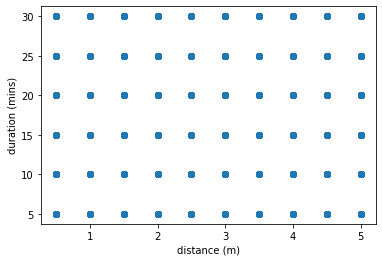

In [ ]:
data = make_input_data()
plt.figure()
plt.scatter(data['distance_grid'], data['duration_grid'])
plt.xlabel('distance (m)')
plt.ylabel('duration (mins)')

distances = data['distances']
durations = data['durations']
symptoms = data['symptoms']
print('{} distances, {}'.format(len(distances), distances))
print('{} durations, {}'.format(len(durations), durations))
print('{} symptoms, {}'.format(len(symptoms), symptoms))
n = len(data['distance_grid'])
print('{} x {} x {} = {}'.format(len(distances), len(durations), len(symptoms), n))

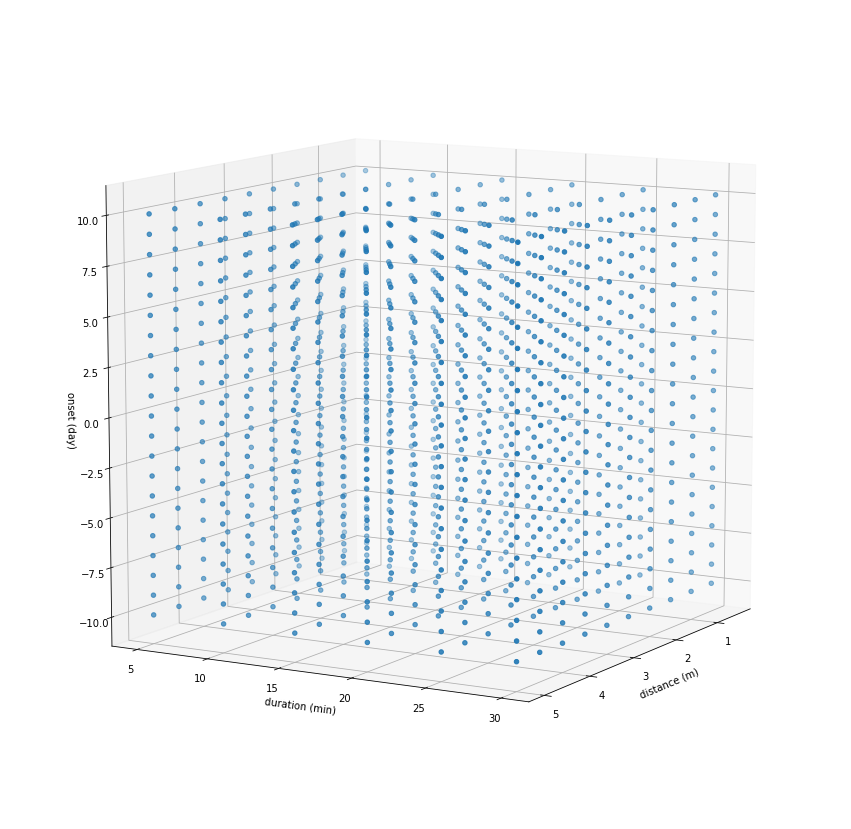

In [ ]:

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
distance = data['distance_grid']
duration = data['duration_grid']
onset = data['symptom_grid']
ax.scatter(distance, duration, onset)
ax.set_xlabel('distance (m)')
ax.set_ylabel('duration (min)')
ax.set_zlabel('onset (day)')
#plt.colorbar()
ax.view_init(elev=10., azim=30)

In [ ]:
def hazard_score_grid(data, params):
  doses = hazard_fun_batch(data['atten_grid'], data['duration_grid'], data['symptom_grid'], params)
  return doses

def prob_infection_grid(data, params):
  doses = hazard_score_grid(data, params)
  ps = 1-np.exp(-params.beta * doses)
  return ps

def risk_score_grid(data, config):
  rs = risk_score_batch(data['atten_grid'], data['duration_grid'], data['symptom_grid'], config)
  return rs

def prob_risk_score_grid(data, config):
  risks = risk_score_grid(data, config)
  qs = 1-np.exp(-config.beta * risks)
  return qs

def risk_score_grid_sample(data, config, ndx):
  rs = risk_score_batch(data['atten_grid_samples'][ndx], data['duration_grid'], data['symptom_grid'], config)
  return rs



## Plot risk / hazard surfaces

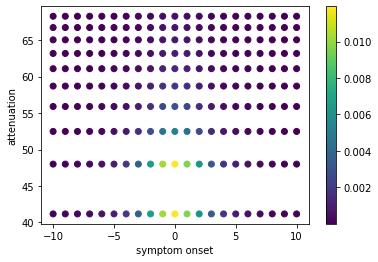

In [ ]:
data = make_input_data()
dur = 15
ndx = data['duration_grid']==dur
attens = data['atten_grid'][ndx]
symptoms = data['symptom_grid'][ndx]
params = ModelParams()
ps = prob_infection_batch(attens, dur, symptoms, params)

plt.figure()
plt.scatter(symptoms, attens, c=ps)
plt.xlabel('symptom onset')
plt.ylabel('attenuation')
plt.colorbar()

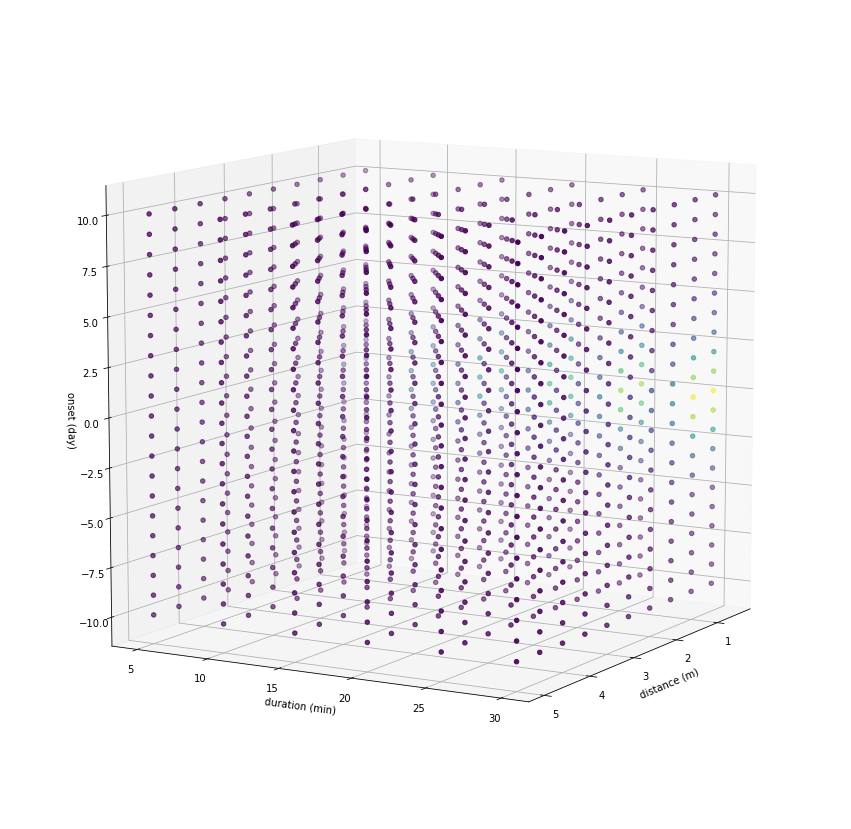

In [ ]:

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
distance = data['distance_grid']
duration = data['duration_grid']
onset = data['symptom_grid']
ps = prob_infection_batch([], duration, onset, params, distance)
ax.scatter(distance, duration, onset, c=ps)
ax.set_xlabel('distance (m)')
ax.set_ylabel('duration (min)')
ax.set_zlabel('onset (day)')
#plt.colorbar()
ax.view_init(elev=10., azim=30)

In [ ]:
def plot_true_risk_surface(data, params, ax, fig, duration=15):
  ps = prob_infection_batch(data['atten_grid_2d'], duration, data['symptom_grid_2d'], params)
  ps2 = np.reshape(ps, data['atten_grid_2d_matrix'].shape)
  surf = ax.plot_surface(data['symptom_grid_2d_matrix'], data['atten_grid_2d_matrix'], ps2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
  ax.set_xlabel('symptom onset')
  ax.set_ylabel('attenuation')
  ax.set_zlabel('Prob. infection')
  ax.set_title('True risk surface, duration {} min'.format(duration))
  fig.colorbar(surf, shrink=0.5, aspect=5)

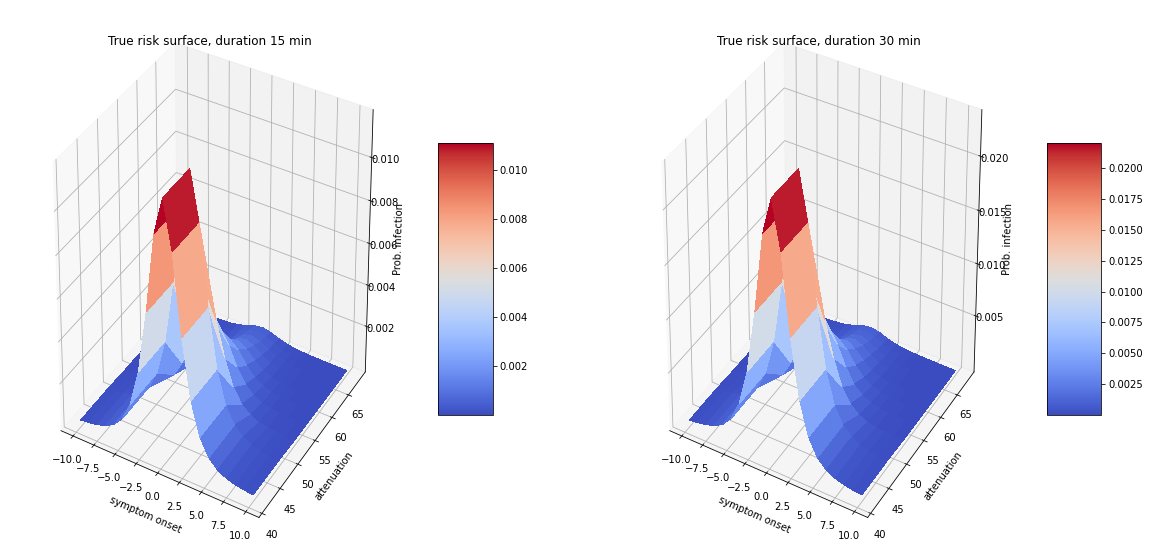

In [ ]:

data = make_input_data()
fig = plt.figure(figsize=(10*2,10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot_true_risk_surface(data, params, ax, fig, duration=15)
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot_true_risk_surface(data, params, ax, fig, duration=30)

In [ ]:
def plot_approx_risk_surface(data, config, ax, fig, duration=15):
  ps = prob_risk_score_batch(data['atten_grid_2d'], duration, data['symptom_grid_2d'], config)
  ps2 = np.reshape(ps, data['atten_grid_2d_matrix'].shape)
  surf = ax.plot_surface(data['symptom_grid_2d_matrix'], data['atten_grid_2d_matrix'], ps2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
  ax.set_xlabel('symptom onset')
  ax.set_ylabel('attenuation')
  ax.set_zlabel('prob. infection')
  ax.set_title(config.name)
  fig.colorbar(surf, shrink=0.5, aspect=5)

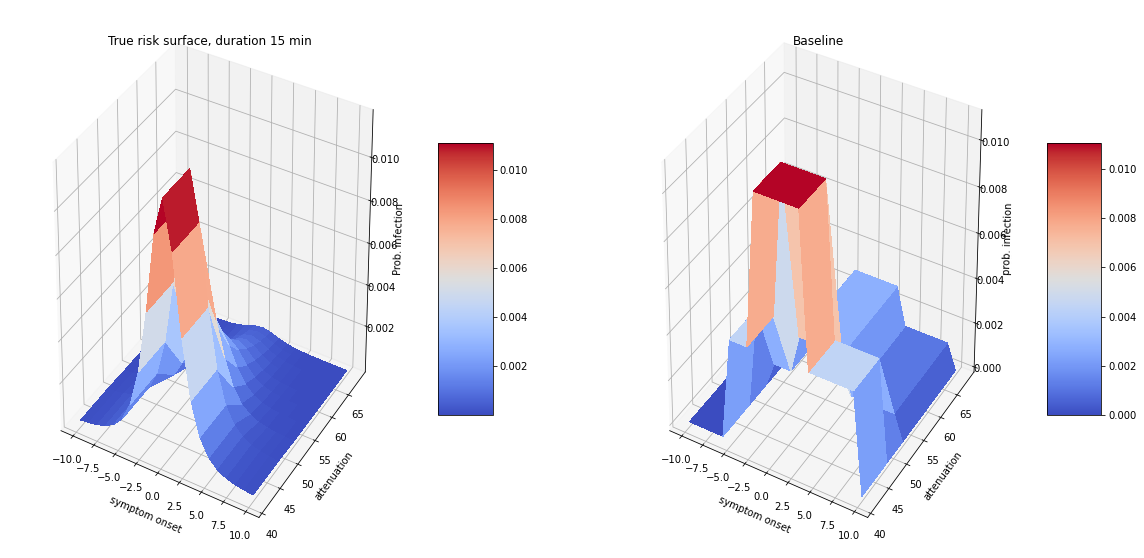

In [ ]:
data = make_input_data()
params = ModelParams()
config = config_baseline
#print(config.beta)
#config.beta = 3*1e-4
fig = plt.figure(figsize=(10*2,10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot_true_risk_surface(data, params, ax, fig)
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot_approx_risk_surface(data, config, ax, fig)

### Compare European variants

The top left plots the 'true' probability of infection (according to parameters in the literature) as a function of symptom onset (x-axis) and attenuation (z-axis), for a single exposure of length 15 minutes. (Longer durations have exactly the same shape, but shift the curve upwards.) 

The top right shows a piecewise bilinear approximation to this using weights and thresholds that I created by hand (based on extrapolating / interpolating settings from Arizona's v1 config). (I call this the "baseline" config, rather than "recommended", to avoid any controversy :)

The bottom left shows the config used by Switzerland. You can see that they (like most HAs) consider risk to be zero if onset<-2, and  constant (wrt onset) otherwise. You can also see that there are only two non-zero attenuation levels (with weights 100 and 50). (Note that   absolute values do not matter, since we can rescale the vertical axis.)

The bottom right is the Ireland config, which is an even worse approximation, since it assigns equal weight to both attenuation levels (100 and 100), thus making the curve have just a single non-zero value wrt the attenuation axis.

In [ ]:
config_list = [config_baseline,  config_swiss, config_ireland]
nrows = 2; ncols = 2; sz = 6;
fig = plt.figure(figsize=(sz*ncols, sz*nrows))
ax = fig.add_subplot(nrows, ncols, 1, projection='3d')
plot_true_risk_surface(data, params, ax, fig)
for i, config in enumerate(config_list):
  ax = fig.add_subplot(nrows, ncols, i+2, projection='3d')
  plot_approx_risk_surface(data, config, ax, fig)
fig.tight_layout()

### Compare hypothetical variants

In [ ]:
inf_levels1, inf_weights1 = make_infectiousness_params_v1()
inf_levels2, inf_weights2 = make_infectiousness_params_v2()
ble_thresholds1, ble_weights1 = make_ble_params_v1()
ble_thresholds2, ble_weights2 = make_ble_params_v2()

assert(len(ble_weights1)==3)
assert(len(ble_weights2)==4)
inf_weights1_nz = inf_weights1[inf_weights1>0]
inf_weights2_nz = inf_weights2[inf_weights2>0]
assert(len(inf_weights1_nz)==6)
assert(len(inf_weights2_nz)==2)

# Same as Arizona
config_inf1_ble1 = RiskConfig(ble_thresholds = ble_thresholds1,
                           ble_weights = ble_weights1,
                           inf_levels = inf_levels1,
                           inf_weights = inf_weights1,
                           name = 'inf-levels:6, ble-buckets:3 (V1)')


config_inf2_ble1 = RiskConfig(ble_thresholds = ble_thresholds1,
                           ble_weights = ble_weights1,
                           inf_levels = inf_levels2,
                           inf_weights = inf_weights2,
                           name = 'inf-levels:2, ble-buckets:4')


config_inf1_ble2 = RiskConfig(ble_thresholds = ble_thresholds2,
                           ble_weights = ble_weights2,
                           inf_levels = inf_levels1,
                           inf_weights = inf_weights1,
                           name = 'inf-levels:6, ble-buckets:4')


config_inf2_ble2 = RiskConfig(ble_thresholds = ble_thresholds2,
                           ble_weights = ble_weights2,
                           inf_levels = inf_levels2,
                           inf_weights = inf_weights2,
                           name = 'inf-levels:2, ble-buckets:4 (V2)')

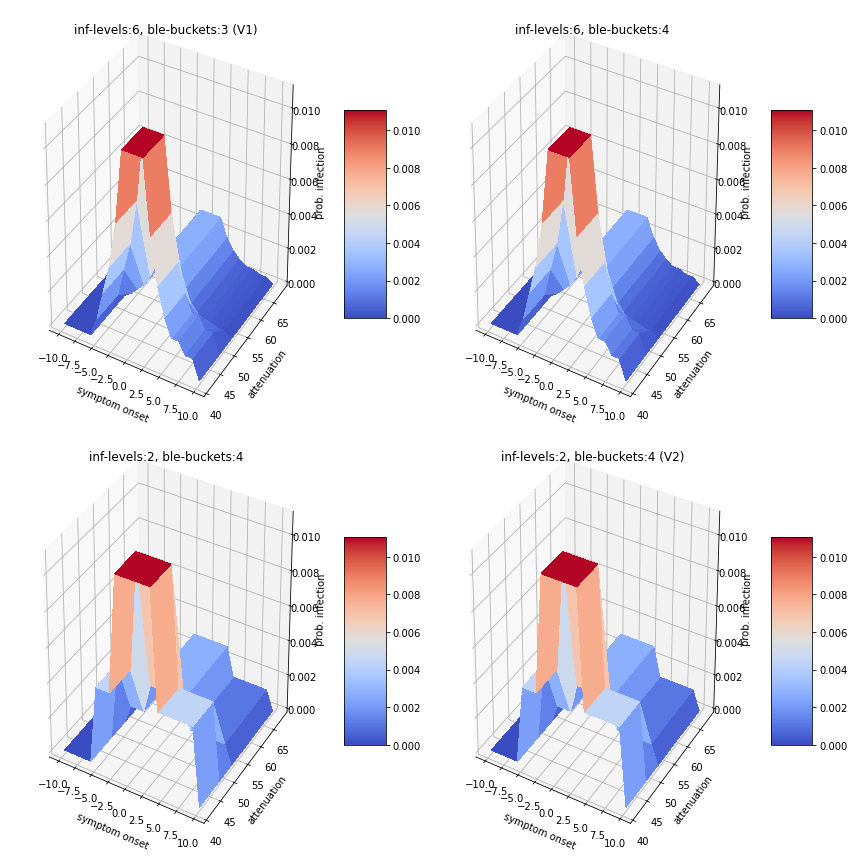

In [ ]:
config_list = [config_inf1_ble1, config_inf1_ble2, config_inf2_ble1, config_inf2_ble2]
nrows = 2; ncols = 2; sz = 6;
fig = plt.figure(figsize=(sz*ncols, sz*nrows))
for i, config in enumerate(config_list):
  ax = fig.add_subplot(nrows, ncols, i+1, projection='3d')
  plot_approx_risk_surface(data, config, ax, fig)
fig.tight_layout()

## Plot ROC curves



We compute the  risk scores $r_n=\text{risk}(x_n)$ for each grid point $x_n$
(or the corresponding approximate probability $q_n=1-e^{-\lambda r_n}$).
We also compute the true infection probabilities, $p_n=p(y_n=1|x_n)$. To compute a ROC curve, we convert these true probabilities into a binary label by comparing to a threshold probability $p^*=p(y=1|x^*)$, where $x^*$ corresponds to a ["meaningful exposure"](https://www.cdc.gov/coronavirus/2019-ncov/php/contact-tracing/contact-tracing-plan/contact-tracing.html#:~:text=For%20COVID%2D19%2C%20a%20close,time%20the%20patient%20is%20isolated.), as defined by the CDC:  $x^*$ is "a close contact is defined as any individual who was within 6 feet of an infected person for at least 15 minutes starting from 2 days before illness onset." We can therefore compute the threhsold $p^*$  as follows:



In [ ]:
def compute_exposure_threshold(params, duration=15, distance=2, symptom_onset=-2):
  atten = dist_to_atten(distance, params.ble_params)
  pthresh = prob_infection_batch(atten, duration, symptom_onset, params)
  return pthresh

params = ModelParams()
pthresh_cdc = compute_exposure_threshold(params)
print(pthresh_cdc)

0.0016377225816829322



Once we have a set of true binary labels $y_n$ and risk scores $r_n$  we can compute the following quantities for each risk threshold $\theta$, from which we can derive the ROC curve, which plots true positive rate (TPR) vs false positive rate (FPR), comptued as follows:

$$
\begin{align}
\text{TP}(\theta) &= \sum_{n=1}^N I[y_n=1] * I[r_n \geq \theta] \\
\text{FP}(\theta) &= \sum_{n=1}^N I[y_n=0] * I[r_n \geq \theta] \\
\text{nPos} &= \sum_{n=1}^N I[y_n=1] \\
\text{nNeg} &= \sum_{n=1}^N I[y_n=0] \\
\text{TPR}(\theta) &= \frac{\text{TP}(\theta)}{\text{nPos}} \\
\text{FPR}(\theta) &= \frac{\text{FP}(\theta)}{\text{nNeg}} 
\end{align}
$$

However, ultimately we want to detect people who are infected, not people who meet the arbitrary CDC threshold of "meaningful exposure". To do this, we can compute an "expected ROC curve", in which we work with "soft labels", i.e., we replace $y_n$ with $p_n=p(y=1|x_n)$. We can easily compute the expected number of false positives and false negatvies as follows:


$$
\begin{align}
E[\text{TP}(\theta)] &= \sum_{n=1}^N p[y_n=1] * I[r_n \geq \theta] \\
E[\text{FP}(\theta)] &= \sum_{n=1}^N p[y_n=0] * I[r_n \geq \theta] \\
E[\text{nPos}] &= \sum_{n=1}^N p[y_n=1]  \\
E[\text{nNeg}] &= \sum_{n=1}^N p[y_n=0] 
\end{align}
$$

The ratio $\frac{E[\text{TP}{\theta}]}{E[\text{nPos}]}$ is biased estimate of the TPR, and similarly for the expected FPR. Fortunately, since the denominator is a constant independent of the risk score, we can ignore it, and just plot ETP vs EFP, which will have the same shape. However, we keep the denominator term, to make the scales of the axes comparable to a traditional ROC curve.

In [ ]:
def compute_ROC_curve(data, params, config,  pthresh=pthresh_cdc):
  probs = prob_infection_grid(data, params)
  scores = risk_score_grid(data, config)
  y = (probs > pthresh)
  fpr, tpr, thresholds = metrics.roc_curve(y, scores)
  auc = metrics.auc(fpr, tpr)
  npos = np.sum(y==1)
  nneg = np.sum(y==0)
  results = {'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds, 'auc': auc,
             'npos': npos, 'nneg': nneg}
  return results

In [ ]:
def expected_roc_curve(probs, scores):
  '''This is just like
  fpr, tpr, thresholds = metrics.roc_curve(y, scores)
  except y(i) is replaced by probs(i) = p(y(i)=1)
  '''
  thresholds = np.sort(np.unique(scores))[::-1] # descending
  N = len(thresholds)
  scores2 = np.tile(scores[:, np.newaxis], N)
  labels = (scores2 >= thresholds) # each column is a different binary labeling
  probs2 = np.tile(probs[:, np.newaxis], N)
  FPs = np.sum(np.multiply(labels, 1-probs2), axis=0)
  TPs = np.sum(np.multiply(labels, probs2), axis=0)
  detections = np.sum(labels, axis=0)
  npos = np.sum(probs)
  nneg = np.sum(1-probs)
  fpr = FPs / nneg
  tpr = TPs / npos
  fdr = FPs / detections
  ppv = TPs / detections
  return fpr, tpr, thresholds

In [ ]:
def compute_eROC_curve(data, params, config):
  probs = prob_infection_grid(data, params)
  scores = risk_score_grid(data, config)
  #y = (probs > pthresh)
  #fpr, tpr, thresholds = metrics.roc_curve(y, scores)
  fpr, tpr, thresholds = expected_roc_curve(probs, scores)
  auc = metrics.auc(fpr, tpr)
  npos = np.sum(probs)
  nneg = np.sum(1-probs)
  results = {'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds, 'auc': auc,
             'npos': npos, 'nneg': nneg}
  return results

In [ ]:

def find_operating_threshold(fpr, tpr, thresholds, target_fpr):
  target_thresh = np.interp(target_fpr, fpr, thresholds)
  target_tpr = np.interp(target_fpr, fpr, tpr)
  return target_thresh, target_tpr


def get_operating_points(res, target_fprs=np.arange(0, 1, 0.01)):
  target_thresholds, target_tprs = find_operating_threshold(
        res['fpr'], res['tpr'], res['thresholds'], target_fprs)
  return target_fprs,  target_tprs, target_thresholds

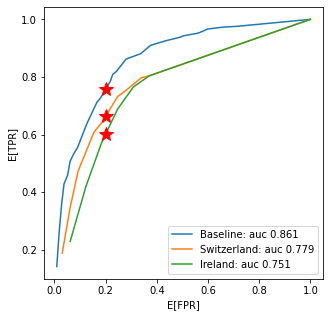

In [ ]:
config_list = [config_baseline, config_swiss, config_ireland]
#config_list = [config_baseline]
params = ModelParams()
data = make_input_data(sigma=0, nsamples=0)
target_fpr = 0.2

fig, ax = plt.subplots(1,1, figsize=(5,5))
for i, config in enumerate(config_list):
  res = compute_eROC_curve(data, params, config)
  fpr = res['fpr']; tpr = res['tpr'];
  thresholds = res['thresholds']; auc = res['auc']
  ax.plot(fpr, tpr, label= '{}: auc {:0.3f}'.format(config.name, auc))
  ax.legend()
  ax.set_xlabel('E[FPR]')
  ax.set_ylabel('E[TPR]')

  target_thresh, target_tpr = find_operating_threshold(
        fpr, tpr, thresholds, target_fpr)
  ax.plot(target_fpr, target_tpr, 'r*', markersize=15)

## Plot ROC curves with error bars 



Since the attenuation is a noisy function of the distance, we can model its impact on the risk score as follows: for each grid point $n$, compute the true distance, duration and symptom onset $x_n=(d_n,t_n,\Delta_n)$ as above; then, sample $M$ noisy attenuations, $\tilde{x}_{nm} = (a_{nm}, t_n, \Delta_n)$, where $a_{nm}$ is sampled from $d_n$; we then compute the corresponding risk scores, $r_{nm} = \text{risk}(\tilde{x}_{nm})$. We then compute $M$ ROC curves using $(p_{1:N}, r_{1:N,m})$. From this, we can compute a confidence interval.

In [ ]:
def compute_eROC_curve_with_errorbars(data, params, config, max_nsamples=20):
  tprs = []
  aucs = []
  thresh_list = []
  median_fpr = np.linspace(0, 1, 100)
  ps = prob_infection_grid(data, params)
  npos = np.sum(ps)
  nneg = np.sum(1-ps)
  nsamples = min(max_nsamples, data['nsamples'])
  for j in range(nsamples):
    rs = risk_score_grid_sample(data, config, j)
    fpr, tpr, thresholds = expected_roc_curve(ps, rs)
    auc = metrics.auc(fpr, tpr)
    interp_tpr = np.interp(median_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc)
    interp_thresh = np.interp(median_fpr, fpr, thresholds)
    thresh_list.append(interp_thresh)
  median_tpr = np.median(tprs, axis=0)
  median_tpr[-1] = 1.0
  median_auc = metrics.auc(median_fpr, median_tpr)
  median_thresh = np.median(thresh_list, axis=0)
  auc_lo = np.quantile(aucs, 0.025, axis=0)
  auc_hi = np.quantile(aucs, 0.975, axis=0)
  std_auc = np.std(aucs)
  tprs_hi = np.quantile(tprs, 0.025, axis=0)
  tprs_lo = np.quantile(tprs, 0.975, axis=0)

  target_fpr = np.arange(0, 1, .01)
  target_thresh, target_tpr = find_operating_threshold(
      median_fpr, median_tpr, median_thresh, target_fpr)

  results = {'fpr': median_fpr, 'tpr': median_tpr, 
             'tprs_lo': tprs_lo, 'tprs_hi': tprs_hi, 
          'median_auc': median_auc, 'auc_lo': auc_lo, 'auc_hi': auc_hi,
          'thresholds': median_thresh, 
          'target_fpr': target_fpr, 'target_thresh': target_thresh, 'target_tpr': target_tpr,
          'npos': npos, 'nneg': nneg
          }
  return results

Below we show the ROC if the distance is estimated perfectly from noise-free attenuation,
as well as what happens when we use noisy samples with varying sigma.
We see that, when the noisy is sufficiently large, small differences between different risk score configurations are no longer significant.

In [ ]:
config_list = [config_baseline, config_swiss, config_ireland]
#config_list = [config_baseline]
params = ModelParams()
target_fpr = 0.2

sigmas = [0, 0.1, 0.5, 1.0]
datasets = []
N = len(sigmas)
for n in range(N):
  np.random.seed(0)
  data = make_input_data(sigma=sigmas[n], nsamples=20)
  datasets.append(data)

fig, axs = plt.subplots(2,2, figsize=(10,10))
axs = np.reshape(axs, (N))
for n in range(N):
  ax = axs[n]
  data = datasets[n]
  for i, config in enumerate(config_list):
    res = compute_eROC_curve_with_errorbars(data, params, config)

    median_fpr = res['fpr']; median_tpr = res['tpr'];
    median_auc = res['median_auc']; median_thresh = res['thresholds']
    tprs_lo = res['tprs_lo']; tprs_hi = res['tprs_hi']
    auc_lo = res['auc_lo']; auc_hi = res['auc_hi'];

    #ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', alpha=0.8)
    ax.plot(median_fpr, median_tpr, lw=2, alpha=0.8, label=config.name)
    ax.set_title('noise={:0.2f}'.format(data['noise_level']))
    ax.fill_between(median_fpr, tprs_lo, tprs_hi, color='grey', alpha=0.4)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend()

    target_thresh, target_tpr = find_operating_threshold(median_fpr, median_tpr, median_thresh, target_fpr)
    ax.plot(target_fpr, target_tpr, 'r*', markersize=15)

# Javascript user interface 


## JS Code 


In [ ]:
import IPython
from google.colab import output
import json


In [ ]:
#levels, weights = make_infectiousness_params_v2()

class NumpyEncoder(json.JSONEncoder):
  """ Special json encoder for numpy types """
  def default(self, obj):
    if isinstance(obj, np.integer):
      return int(obj)
    elif isinstance(obj, np.floating):
      return float(obj)
    elif isinstance(obj, np.ndarray):
      return obj.tolist()
    return json.JSONEncoder.default(self, obj)



In [ ]:
JS = '''
var tHeight = 200
var tWidth = 400

var color = {
  red: '#F44336',
  orange: '#FF9800',
  yellow: '#f1f70e',
  green: '#4CAF50',
  grey: '#ccc',
}

d3.select('.graph').html(`
  <div class='select'></div>
  <div class='top'>
    <div class='ble'></div>
    <div class='onset'></div>
    <div class='right-sliders'>
      <div class='sim'></div>
      <div class='viral'></div>
    </div>
  </div>
  <div class='bot'></div>
`)

d3.select('.bot').html('')

var ble = initBLE()
var onset = initOnset()
var sim = initSim()
var viral = initViral()
var graphs = ['Custom Config'].map(initGraph)
var surface = initSurface()
var select = initSelect()

d3.selectAll('h2')
  .each(function(d){ d3.select(this).datum({isActive: 1})})
  .on('click', function(d){
    d.isActive = !d.isActive
    d3.select(this).parent().classed('inactive', !d.isActive)
  })


window.js_drag_end = function(pyData){
  var [pyDataCustom, pyDataDefault] = pyData
  window.pyData = pyData

  graphs.forEach((d, i) => d.dragEnd(i ? defaultScore : pyDataCustom))

  surface(pyDataCustom)
  sim.render(pyDataCustom.ble_curve_data)
  viral.render(pyDataCustom.transmission_data)
}

window.js_drag_start = function(array){
  graphs[0].dragStart(array)
}

function dragStart(configs){
  window.dragStartData = null
  if (!window.ENABLE_DRAG_LINES) return //console.log('drag disabled')

  google.colab.kernel.invokeFunction('py_drag_start', [configs], {})
}

async function dragEnd(){
  window.dragStartData = null

  var js_config = generateJSConfig()

  if (window.google && window.google.colab){
    google.colab.kernel.invokeFunction('py_drag_end', [js_config], {})
  } else{
    var pyData = await post('drag_end_data', js_config)
    window.pyData = pyData
    window.js_drag_end(pyData)
  }

}

function generateJSConfig(name='js'){
  return {
    ble_thresholds: ble.thresholds.sorted.map(Math.round),
    ble_weights: ble.weights.map(d => d.w).map(Math.round),
    inf_weights: [0].concat(onset.weights.map(d => d.w)),
    inf_levels: onset.levels.map(d => d.l),
    sigma: sim.sigma.v,
    distance_slope: viral.distance_slope.v,
    distance_inflection: viral.distance_inflection.v,
    distance_Dmin: viral.distance_Dmin.v,
    distance_fun: viral.distance_fun,
    name
  }
}

function initSim(){
  var sel = d3.select('.sim').html('')
  sel.append('h2.slide-left').text('Simulation Settings')
    .st({marginBottom: 15})


  var sliders = [
    {
      s: 'sigma',
      pp: 'Bluetooth Noise',
      u: '',
      step: .1,
      v: .2,
      r: [0, .5]
    },
  ]

  var rv = addSliders(sel, sliders)

  rv.render = function({distances, mu, attens}){
    var constainerDiv = sel.selectAppend('div.tiny').html('')
      .st({top: -155, left: 240, height: 0, position: 'relative', marginBottom: -20})

    var c = d3.conventions({
      sel: constainerDiv.append('div'),
      height: 110, 
      width: 110,
    })

    c.x.domain(d3.extent(distances.concat(5)))
    c.y.domain(d3.extent(attens)).domain([40, 100]).clamp(1)

    c.xAxis.ticks(4)
    c.yAxis.ticks(5)
    d3.drawAxis(c)
    addAxisLabel(c, 'Distance (m)', 'Attenuation (dB)')
    c.svg.select('.y .label').translate([c.width + 30, c.height/2])

    var line = d3.line().x((d, i) => c.x(distances[i])).y(c.y)

    c.svg.append('path').at({d: line(mu), stroke: '#000', fill: 'none', strokeWidth: 2})

    c.svg.appendMany('circle', attens)
      .at({r: 1, fill: '#000', opacity: .4})
      .translate((d, i) => [c.x(distances[i]), c.y(d)])
  }


  return rv
}

function initViral(){
  var sel = d3.select('.viral').html('')

  sel.append('h2.slide-left').text('Viral Transmission v. Distance')
    .st({marginBottom: 30})

  var constainerDiv = sel.selectAppend('div.tiny').html('')
    .st({top: -39, left: 240, height: 15, position: 'relative', marginBottom: -20})

  var selectSel = sel
    .append('select').st({marginTop: -30, position: 'relative', top: -18})
    .on('change', function(){
      updateDistanceFun(this.value)
      dragEnd()
    })
    .appendMany('option', ['sigmoid', 'quadratic', 'spline'])
    .text(d => d)
    .at({value: d => d})


  var sliders = [
    {
      s: 'distance_slope',
      pp: 'Steepness',
      u: '',
      step: .1,
      v: 2,
      r: [.1, 5],
      type: 'sigmoid',
    },
    {
      s: 'distance_inflection',
      pp: 'Inflection',
      u: '',
      step: .1,
      v: 2,
      r: [.1, 10],
      type: 'sigmoid',
    },
    {
      s: 'distance_Dmin',
      pp: 'Dmin',
      u: '',
      step: .1,
      v: 2,
      r: [.1, 5],
      type: 'quadratic',
    }
  ]

  function updateDistanceFun(fnStr){
    rv.distance_fun = fnStr
    rv.sliderSel.st({display: d => d.type == rv.distance_fun ? '' : 'none'})
  }

  var rv = addSliders(sel, sliders)
  updateDistanceFun(selectSel.data()[0])

  rv.render = function({x, y}){
    var c = d3.conventions({
      sel: constainerDiv.html('').append('div'),
      height: 110, 
      width: 110,
    })

    c.x.domain([0, 5])

    c.xAxis.ticks(5)
    c.yAxis.ticks(5)
    d3.drawAxis(c)
    addAxisLabel(c, 'Distance (m)', 'Distance Factor')
    c.svg.select('.y .label').translate([c.width + 30, c.height/2])
    c.svg.select('.x .label').translate([c.width/2, -c.height])

    var line = d3.line().x((d, i) => c.x(x[i])).y(c.y)
    c.svg.append('path').at({d: line(y), stroke: '#000', fill: 'none', strokeWidth: 2})
  }

  return rv
}

function initGraph(type, index){
  var sel = d3.select('.bot').append('div')
  var aucTextSel = sel.append('h2')
  var c = d3.conventions({
    sel: sel,
    height: 250,
    width: 250,
    margin: {bottom: 100, left: 50, right: 50, top: 100}
  })


  c.svg
    .on('mousemove', function(){
      var fpr = d3.mouse(this)[0]/c.width

      graphs.forEach(d => {
        d.fpr = fpr
        d.renderFPR()
      })
    })
    .append('rect').at({width: c.width, height: c.height, fillOpacity: 0})


  var line = d3.line()
    .x(d => c.x(d.fpr))
    .y(d => c.y(d.tpr))

  var area = d3.area()
    .x(d => c.x(d.fpr))
    .y0(d => c.y(d.tprs_hi))
    .y1(d => c.y(d.tprs_lo))


  c.xAxis.ticks(5)
  c.yAxis.ticks(5)
  d3.drawAxis(c)

  addAxisLabel(c, 'False Positive Rate', 'True Positive Rate')

  var areaSel = c.svg.append('path').at({fill: '#ddd'})

  var randomPathSel = c.svg.append('path').at({stroke: '#999', fill: 'none', strokeWidth: 2, strokeDasharray: '3 3'})

  var altPathSel = c.svg.append('g').appendMany('path', d3.range(256))
    .st({stroke: '#999', fill: 'none'})

  var pathSel = c.svg.append('path').at({stroke: '#000', strokeWidth: 2, fill: 'none'})

  // var aucTextSel = c.svg.append('text')
  //   .at({fontSize: 14, x: c.width/2, y: -20, textAnchor: 'middle'})
  //   .st({fontWeight: 300})

  function scoreToData(score){
    var {fpr, tpr, tprs_lo=[], tprs_hi=[]} = score

    var rv = fpr.map((d, i) => ({
      fpr: fpr[i], 
      tpr: tpr[i],
      tprs_lo: tprs_lo[i],
      tprs_hi: tprs_hi[i],
    }))

    rv.auc = score.auc

    return rv
  }

  function scoreToTarget(score){
    var {target_fpr, target_tpr, target_thresh} = rv.score

    return target_fpr.map((d, i) => ({
      fpr: target_fpr[i],
      tpr: target_tpr[i],
      thresh: target_thresh[i],
    }))
  }
  
  var fmt = d3.format('.3f')
  var fmtS = d3.format('.1f')

  function dragEnd(score){
    rv.data = []

    rv.score = score
    rv.lineData = scoreToData(score)
    rv.targetData = scoreToTarget(score)
    pathSel.at({d: line(rv.targetData)})
    areaSel.at({d: area(rv.lineData)}).st({opacity: 1})
    randomPathSel.at({d: line(rv.lineData)}).st({opacity: 1})

    aucTextSel.text('AUC: ' + fmt(score.median_auc) + ' [' + [score.auc_lo, score.auc_hi].map(fmt).join(', ') + ']')

    altPathSel.at({opacity: 0})

    renderFPR()
  }

  function dragStart(scores){
    fprSel.st({opacity: 0})
    areaSel.st({opacity: 0})


    rv.data = scores.map(scoreToData)

    altPathSel
      .data(rv.data)
      .at({
        d: line,
        opacity: (d, i) => i >= rv.data ? 0 : .2,
      })

    rv.drag()
  }

  function drag(index=rv.index){
    rv.index = index
    if (!rv.data.length) return rv.index = index

    aucTextSel.text(type + ' AUC: ' + fmt(rv.data[index].auc))

    pathSel.at({d: line(rv.data[index])})
  }

  var fprSel = c.svg.append('g')
  fprSel.append('circle').at({r: 4, fill: 'none', stroke: 'orange', strokeWidth: 2})
  var fprText    = fprSel.append('text').translate([10, 15]).st({fontSize: 12, fontWeight: 300, fontFamily: 'sans-serif'})
  var tprText    = fprSel.append('text').translate([10, 30]).st({fontSize: 12, fontWeight: 300, fontFamily: 'sans-serif'})
  var ppvText    = fprSel.append('text').translate([10, 45]).st({fontSize: 12, fontWeight: 300, fontFamily: 'sans-serif'})
  var threshText = fprSel.append('text').translate([10, 60]).st({fontSize: 12, fontWeight: 300, fontFamily: 'sans-serif'})

  function renderFPR(){
    if (!rv.score) return

    var {target_fpr, target_tpr, target_thresh} = rv.score

    var i = d3.clamp(0, Math.round(rv.fpr*100), 99)

    fprSel
      .st({opacity: 1})
      .translate([c.x(target_fpr[i]), c.y(target_tpr[i])])
 
    var rnd = Math.round
    var {nneg, npos} = window.pyData[0]

    var nfp = target_fpr[i]*nneg
    var ntp = target_tpr[i]*npos

    var npred_pos = nfp + ntp
    var precision = ntp / npred_pos // PPV

    fprText.text('FPR: ' + fmtS(nfp) + '/' + rnd(nneg) + ' = ' + fmt(target_fpr[i]))
    tprText.text('TPR: ' + fmtS(ntp) + '/' + rnd(npos) + ' = ' + fmt(target_tpr[i]))
    ppvText.text('PPV: ' + fmtS(ntp) + '/' + rnd(npred_pos) + ' = ' + fmt(precision))
    threshText.text('Thresh: ' + fmt(target_thresh[i]))

  }

  var rv = {dragEnd, dragStart, drag, renderFPR, fpr: .1, data: [], lastIndex: -1}
  return rv
}

function initSurface(){
  var charts = [
    {
      title: 'ENS Risk',
      key: 'true_risk_surface'
    },
    {
      title: 'Model Risk',
      key: 'approx_risk_surface'
    }
  ]

  var chartSel = d3.select('.bot').appendMany('div.surface', charts)
    .append('div')
    .append('h2').text(d => d.title).st({marginBottom: -30, zIndex: 20, position: 'relative'})
    .parent().append('div')

  return py_data => {
    chartSel.each(function(d){
      var sel = d3.select(this).st({marginTop: -60})
      sel.html('')
      d.node = this

      var data = [{
        z: py_data[d.key].ps2, 
        type: 'surface',
        colorbar: {
          thichness: 5,
        },
        colorscale: 'Viridis',
        showscale: false,
        // x: [1, 2, 3, 4],
      }]

      var tickfont = {
        color: '#A5A5A5',
        family: 'sans-serif',
        size: 12
      }

      var xTicks = [-10, -5, 0, 5, 10]

      var y = d3.scaleLinear().range([0, 9]).domain(d3.extent(py_data[d.key].atten_grid_2d))
      var yTicks = y.ticks(5)

      d.layout = {
        autosize: false,
        width: 400,
        height: 400,
        margin: {l: 0, r: 0, b: 0, t: 0},
        scene: {
          xaxis: {
            title: 'onset',
            ticktext: xTicks.map(d => d > 0 ? '+' + d : d),
            tickvals: xTicks.map(i => py_data[d.key].symptom_grid_2d_matrix[0].indexOf(i)),
            tickfont
          },
          yaxis: {
            title: 'attenuation',
            ticktext: yTicks,
            tickvals: yTicks.map(y),
            tickfont
          },
          zaxis: {
            title: 'infection prob.',
            tickfont
          },
          camera: {
            eye: {x: 0.7575368690502688, y: 2.0162026227202694, z: 0.22037439997745298}
          }
        },
      }

      Plotly
        .newPlot(sel.node(), data, d.layout, {displayModeBar: false})
        .then(function() {
          sel.node().on('plotly_relayouting', function(e) {
            charts.forEach(other => {
              if (other == d) return
              var scene = JSON.parse(JSON.stringify(other.layout.scene))
              scene.camera = e['scene.camera']
              // layout.camera = e['scene.camera']

              // // other.layout.camera = e['scene.camera']
              Plotly.relayout(other.node, {scene})
            })
          })
        })
    })

  }
}

function initBLE(){
  var sel = d3.select('.ble').html('')
  sel.append('h2').text('Bluetooth Attenuation Settings')

  var c = d3.conventions({
    sel: sel.append('div'),
    totalHeight: tHeight,
    totalWidth: tWidth,
    margin: {right: 70, left: 50},
  })


  var weights = [
    {
      str: 'Immediate-Near',
      p: [0, 30],
      w: 150,
      fill: color.red,
    },
    {
      str: 'Near-Medium',
      p: [30, 50],
      w: 100,
      fill: color.orange,
    },
    {
      str: 'Medium-Far',
      p: [50, 60],
      w: 50,
      fill: color.yellow
    },
    {
      str: 'Other',
      p: [60, 100],
      w: 10,
      fill: color.green,
    },
  ]

  weights.forEach((d, i) => d.i = i)
  var thresholds = weights.slice(0, 3).map((d, i) => ({i, t: d.p[1]}))

  c.x.domain([0, 100]).interpolate(d3.interpolateRound)
  c.y.domain([0, 200]).interpolate(d3.interpolateRound).clamp(1)

  c.xAxis.ticks(5)
  c.yAxis.ticks(5)
  d3.drawAxis(c)
  addAxisLabel(c, 'Attenuation (dB)', 'Weight')

  var gSel = c.svg.append('g').translate([.5, .5])

  var wSel = gSel.appendMany('rect', weights)
    .at({
      fill: d => d.fill,
      stroke: '#000',
    })

  var rs = 14

  var sideDragSel = gSel.appendMany('g.drag', thresholds)
    .st({cursor: 'ew-resize'})
    .call(d3.drag()
      .on('start', function(d){
        var configs = d3.range(100 + 1).map(i => {
          var config = generateJSConfig()
          config.ble_thresholds[d.i] = i
          config.ble_thresholds = _.sortBy(config.ble_thresholds)

          return config
        })

        dragStart(configs)
      })
      .on('drag', function(d){
        var x = d3.mouse(c.svg.node())[0]
        d.t = d3.clamp(0, c.x.invert(x), 100)

        render()
        graphs[0].drag(Math.round(d.t))
      })
      .on('end', dragEnd)
    )

  var sideDragRectSel = sideDragSel.append('rect')
    .at({width: rs, x: -rs/2, height: c.height})

  var topDragSel = gSel.appendMany('g.drag', weights)
    .st({cursor: 'ns-resize'})
    .call(d3.drag()
      .on('start', function(d){
        var configs = d3.range(200 + 1).map(i => {
          var config = generateJSConfig()
          config.ble_weights[d.i] = i

          return config
        })

        dragStart(configs)
      })
      .on('drag', function(d){
        var y = d3.mouse(c.svg.node())[1]
        d.w = c.y.invert(y)

        render()
        graphs[0].drag(Math.round(d.w))
      })
      .on('end', dragEnd)
    )

  var topDragRectSel = topDragSel.append('rect')
    .at({height: rs, y: -rs/2})

  topDragSel.append('text.color-label')
    .text(d => d.str.split('-')[0])
    .at({fontFamily: 'sans-serif', fontSize: 10, dy: '-.3em', x: 1, fill: d => d3.color(d.fill).darker(.5)})


  function render(){
    var ts = thresholds.sorted = _.sortBy(thresholds.map(d => d.t))
    weights[0].p = [0, ts[0]]
    weights[1].p = [ts[0], ts[1]]
    weights[2].p = [ts[1], ts[2]]
    weights[3].p = [ts[2], 100]

    wSel.at({
      x: d => c.x(d.p[0]),
      width: d => c.x(d.p[1]) - c.x(d.p[0]),
      y: d => c.y(d.w),
      height: d => Math.max(.1, c.height - c.y(d.w)),
    })

    sideDragSel.translate(d => c.x(d.t), 0)

    topDragSel.translate(d => [c.x(d.p[0]), c.y(d.w)])
    topDragRectSel.at({width: d => c.x(d.p[1]) - c.x(d.p[0])})
  }
  render()


  return {sel, weights, thresholds, render}
}

function initOnset(){
  var sel = d3.select('.onset').html('')
  sel.append('h2.slide-right').text('Symptom Onset Settings')

  var c = d3.conventions({
    sel: sel.append('div'),
    totalHeight: tHeight,
    totalWidth: tWidth,
    margin: {right: 100, bottom: 130, top: 40},
  })

  var levels = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
    .map((l, i) => ({l, day: i - 14}))

  var letterData = d3.cross(levels, [0, 1, 2])
  letterData.forEach(d => {
    d.level = d[0]
    d.letter = d[1]
    d.str = 'DSH'[d.letter]
    d.strColor = [color.green, color.orange, color.red][d.letter]
  })

  c.x.domain([-14, 14])
  c.y.domain([0, 2])
  c.xAxis.tickValues([-14, -7, 0, 7, 14])
  d3.drawAxis(c)
  c.svg.select('.y').translate(35, 0).selectAll('.tick').remove()
  addAxisLabel(c, 'Date of Onset', 'Infectiousness')

  var letterSel = c.svg.appendMany('text.letter', letterData)
    .text(d => 'DSH'[d.letter])
    .at({
      x: d => c.x(d.level.day),
      y: d => c.y(d.letter),
      fill: d => d.strColor,
      textAnchor: 'middle',
      cursor: 'pointer',
    })
    .on('click', d => {
      d.level.l = d.letter
      render()
      dragEnd()
    })


  var weights = [
    {
      i: 0, 
      w: 100, 
      text: 'Standard weight', 
      fill: color.orange,
    },
    {
      i: 1, 
      w: 100, 
      text: 'High weight', 
      fill: color.red,
    },
  ]

  var bh = 20
  var leftPad = 120
  var x = d3.scaleLinear().domain([0, 250]).range([0, c.width - 110]).clamp(1)

  var botSel = c.svg.append('g').translate([.5 + leftPad, c.margin.bottom - 40.5])
  var wSel = botSel.appendMany('g', weights)
    .translate(d => d.i*(bh + 10), 1)

  wSel.append('text').text(d => d.text)
    .at({textAnchor: 'end', x: -3, fill: d => d.fill, y: bh/2, dy: '.33em'})

  var dragFn = d3.drag()
    .on('start', function(d){
      var configs = d3.range(256).map(i => {
        var config = generateJSConfig()
        config.inf_weights[d.i + 1] = i

        return config
      })

      dragStart(configs)
    })
    .on('drag', function(d){
      var xPos = d3.mouse(botSel.node())[0]
      d.w = x.invert(xPos)

      render()
      graphs[0].drag(Math.round(d.w))
    })
    .on('end', dragEnd)

  var rectSel = wSel.append('rect')
    .at({height: bh, fill: d => d.fill, width: 100, stroke: '#000', cursor: 'ew-resize'})
    .call(dragFn)

  var numSel = wSel.append('text.light-num')
    .at({x: 5, y: bh/2, dy: '.33em', pointerEvents: 'none'})


  function render(){
    letterSel.classed('inactive', d => d.level.l != d.letter)

    rectSel.at({width: d => Math.max(1, x(d.w))})
    numSel.translate(d => x(d.w), 0).text(d => Math.round(d.w))
  }
  render()

  return {sel, levels, weights, render}
}

function initSelect(){
  var selectSel = d3.select('.select').html('')
    .append('select')
    .on('change', function(){
      var m = presetConfigs.filter(d => d.name == this.value)[0]
      if (!m) return console.log(this.value)
      onSelect(m)
    })
    .appendMany('option', presetConfigs)
    .text(d => d.name)
    .at({value: d => d.name})

  function onSelect(presetConfig){

    presetConfig.ble_thresholds.forEach((d, i) => ble.thresholds[i].t = d)
    presetConfig.ble_weights.forEach((d, i) => ble.weights[i].w = d)
    ble.render()
    
    // TODO read more than one weight?
    presetConfig.inf_levels.forEach((d, i) => onset.levels[i].l = d)
    presetConfig.inf_weights.slice(1).forEach((d, i) => onset.weights[i].w = d)
    onset.render()

    dragEnd()
  }
  onSelect(presetConfigs[0])
}

function addAxisLabel(c, xText, yText){
  c.svg.select('.x').append('g.label')
    .translate([c.width/2, 35])
    .append('text')
    .text(xText)
    .at({textAnchor: 'middle'})
    .st({fill: '#000', fontSize: 12, fontWeight: 600})

  c.svg.select('.y')
    .append('g.label')
    .translate([-50, c.height/2])
    .append('text')
    .text(yText)
    .at({textAnchor: 'middle', transform: 'rotate(-90)'})
    .st({fill: '#000', fontSize: 12, fontWeight: 600})
}

function addSliders(sel, sliders, renderFn){
  var sliderSel = sel.appendMany('div', sliders)
    .st({marginBottom: 20})

  var textSel = sliderSel.append('div')
    .st({fontSize: 12, fontFamily: 'sans-serif'})

  sliderSel.append('input')
    .at({
      type: 'range',
      value: d => d.v,
      min: d => d.r[0],
      max: d => d.r[1],
      step: d => d.step || 1
    })
    .on('input', function(d){
      d.v = +this.value
      render()

    })
    .on('change', function(d){
      d.v = +this.value
      render()
      dragEnd()
    })

  render()

  function render(){
    textSel.html(d => '<b>' + (d.pp || d.s) + '</b>: ' + d.v + ' ' + d.u)

    if (renderFn) renderFn()
  }

  var rv = {sliderSel}
  sliders.forEach(d => rv[d.s] = d)

  return rv
}

async function post(route, obj){
  var body = JSON.stringify(obj)
  var cacheKey = body + route

  if (!window.postCache) postCache = {}
  if (postCache[cacheKey]) return postCache[cacheKey]

  var root = window.location.href.includes('localhost') ? 'http://localhost:5001/' : '/'
  var res = await fetch(root + route, {method: 'POST', body})

  var rv = await res.json()
  postCache[cacheKey] = rv

  return rv
}
'''


In [ ]:
CSS = '''
body{
  width: 1390px;
  margin: 0px auto;
  padding: 20px;
  height: 10px !important;
  font-family: 'Roboto', serif;

}

h2{
  background: #000;
  color: #fff;
  padding: 3px;
  margin-right: 30px;
  margin-left: 30px;
  /*width: calc(100% - 50px);*/
 /*display: inline-block;*/
  /*margin: 0px auto;*/
  text-align: center;
}

h2.slide-left{
  position: relative;
  left: -30px;
  width: 220px;
}
h2.slide-right{
  position: relative;
  left: -18px;
  /*width: 220px;*/
}

.binary h2{
  margin-left: 0px;
  margin-right: 0px;
  position: relative;
  left: -8px !important;
}

.rendered_html{
  /*display: none;*/
}

.tooltip {
  top: -1000px;
  position: fixed;
  padding: 10px;
  background: rgba(255, 255, 255, .90);
  border: 1px solid lightgray;
  pointer-events: none;
}
.tooltip-hidden{
  opacity: 0;
  transition: all .3s;
  transition-delay: .1s;
}

@media (max-width: 590px){
  div.tooltip{
    bottom: -1px;
    width: calc(100%);
    left: -1px !important;
    right: -1px !important;
    top: auto !important;
    width: auto !important;
  }
}

svg{
  overflow: visible;
}

.domain{
  display: none;
}

text{
  /*pointer-events: none;*/
  text-shadow: 0 1px 0 #fff, 1px 0 0 #fff, 0 -1px 0 #fff, -1px 0 0 #fff;
}

text.color-label{
  /*pointer-events: none;*/
  /*text-shadow: none;*/
}



.top > div{
  display: inline-block;
  width: 360px;
  vertical-align: top;
}

.bot > div{
  vertical-align: top;
}

.sim, .viral{
  width: 300px !important;

  position: relative;
  z-index: 100;
}
.sim h2, .viral h2{
  text-align: left;
}

.viral{
  height: 160px;
}


.drag{
  user-select: none;
  -webkit-tap-highlight-color: rgba(0,0,0,0);
}
.drag rect{
  fill: rgba(0,0,0,0);
}
.drag:hover rect{
  fill: rgba(0,0,0,.3);
}

h2{
  margin-top: 30px;
  text-align: center;
  font-size: 16px;
}

.onset h2{
  position: relative;
  /*left: -40px;*/
}

.axis .tick text{
  opacity: .5;
}
.axis .tick line{
  opacity: .4;
}



.letter:hover{
  font-weight: 700;
}

.letter.inactive{
  fill: #ddd;
}

.bot > div {
  display: inline-block;
  vertical-align: top;
}






input[type="range" i] {
  background-color:#000;
  -webkit-appearance: none;
  height:1px;
  border: none;
  /*overflow: hidden;*/
}

input[type='range']::-webkit-slider-thumb {
  -webkit-appearance: none;
  width: 13px;
  height: 13px;
  border-radius:15px;
  cursor: ew-resize;
  background: #000;
  /*box-shadow: -200px 0 0 200px #999;*/
}

input:focus {
  outline-width: 0;
}


.light-num{
  fill:rgb(0, 0, 0);
  font-family:sans-serif;
  font-size:12px;
  font-weight:400;
  /*opacity: .5;*/
}


.modebar-container{
  display: none !important;
}

.surface{
  /*width: 300px;*/
  /*width: 200px;*/
  position: relative;
  z-index: 0;
  margin-left: -20px;
  min-width: 200px;
}

h2{
  cursor: pointer;
  user-select: none;

}

.inactive > * {
  opacity: 0;
}
.inactive > h2{
  opacity: .4 !important;
}
'''

In [ ]:

HTML = '''
  <script>
    window.presetConfigs = [
       {
        name: 'Baseline (v2)',
        ble_thresholds: [50, 70, 80],
        ble_weights: [239, 60 , 6, 1], 
        inf_levels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,  1, 1, 0, 0, 0, 0, 0],
        inf_weights:  [0 , 40, 100],
      },
      {
        name: 'Switzerland (v1/v2)',
        ble_thresholds: [55, 63],
        ble_weights: [100, 50, 0],
        inf_levels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        inf_weights: [0, 100, 100],
      },
      {
        name: 'Ireland (v1/v2)',
        ble_thresholds: [56, 62],
        ble_weights: [100, 100, 0],
        inf_levels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        inf_weights: [0, 100, 100],
      },
      {
        name: 'Virginia (v1/v2)',
        ble_thresholds: [55, 63],
        ble_weights: [100, 50, 0],
        inf_levels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        inf_weights: [0, 100, 100],
      },
    ]
  </script>


  <script>window.ENABLE_DRAG_LINES = false</script>

  <div class='graph'></div>
  <link href='https://fonts.googleapis.com/css?family=Roboto+Slab:400,500,700|Roboto:700,500,300' rel='stylesheet' type='text/css'>  
  <script src='https://roadtolarissa.com/colab-sliders/d3_.js'></script>
  <script src='https://roadtolarissa.com/colab-sliders/plotly-1.56.0.min.js?cache=4'></script>

  <link xrel='stylesheet' href='https://roadtolarissa.com/colab-sliders/style.css?cache=4'>
  <script xsrc='https://roadtolarissa.com/colab-sliders/watch-files.js?cache=4'></script>
  <script xsrc='https://roadtolarissa.com/colab-sliders/script.js?cache=4'></script>
'''

HTML = HTML + '<style>' + CSS + '</style>'
HTML = HTML + '<script>' + JS + '</script>'


def extract_params_from_js(js_settings):
  params_js = ModelParams(
    distance_fun = js_settings['distance_fun'],
    distance_Dmin = js_settings['distance_Dmin'],
    distance_slope = js_settings['distance_slope'],
    distance_inflection = js_settings['distance_inflection'],
    ble_params = BleParams(), # okay to hard-code
    infectiousness_fun = 'skew-logistic' # okay to hard-code
  )
  return params_js

def parse_js_settings(js_settings):
  #published weights are in percentages, so we divide by 100
  return RiskConfig(
    ble_thresholds = np.array(js_settings['ble_thresholds']),
    ble_weights = np.array(js_settings['ble_weights'])/100,
    inf_weights = np.array(js_settings['inf_weights'])/100,
    inf_levels = np.array(js_settings['inf_levels']),
    name = js_settings['name']
  )

np.random.seed(0)
sigmaToData = {}
data_noiseless = make_input_data(sigma=0, nsamples=0)


def fmt_surface_data(data, ps):
  ps2 = np.reshape(ps, data['atten_grid_2d_matrix'].shape)
  return {
    'ps2': ps2, 
    'atten_grid_2d_matrix': data['atten_grid_2d_matrix'],
    'atten_grid_2d': data['atten_grid_2d'],
    'symptom_grid_2d': data['symptom_grid_2d'],
    'symptom_grid_2d_matrix': data['symptom_grid_2d_matrix'],
  }

def calc_true_risk_surface(data, params, duration=15):
  ps = prob_infection_batch(data['atten_grid_2d'], duration, data['symptom_grid_2d'], params)
  return fmt_surface_data(data, ps)

def calc_approx_risk_surface(data, config, duration=15):
  ps = prob_risk_score_batch(data['atten_grid_2d'], duration, data['symptom_grid_2d'], config)
  return fmt_surface_data(data, ps)

def calc_ble_curve_data(sigma):
  ble_params = BleParams()
  distances = np.arange(1, 5, 0.01)
  mu = dist_to_atten(distances, ble_params)
  np.random.seed(0)
  attens = dist_to_atten_sample(distances, ble_params, sigma)
  return {'mu': mu, 'attens': attens, 'distances': distances}

def calc_transmission_data(js_settings):
  x = np.linspace(0, 5, 100)
  if js_settings['distance_fun'] == 'sigmoid':
    y = transmission_vs_distance_sigmoid(x, js_settings['distance_slope'], js_settings['distance_inflection'])
  elif js_settings['distance_fun'] == 'quadratic':
     y = transmission_vs_distance_quadratic(x, js_settings['distance_Dmin'])
  elif js_settings['distance_fun'] == 'spline':
    y = transmission_vs_distance_spline(x)
  return {'x': x, 'y': y}

def py_drag_end(js_settings):
  config_js = parse_js_settings(js_settings)
  params_js = extract_params_from_js(js_settings)

  sigma = js_settings['sigma']
  if (sigma not in sigmaToData):
    sigmaToData[sigma] = make_input_data(sigma=sigma, nsamples=20)
  data_noisy = sigmaToData[sigma]

  #custom_dict = compute_ROC_curve_with_errorbars(data_noisy, params_js, config_js, pthresh=pthresh_cdc)
  custom_dict = compute_eROC_curve_with_errorbars(data_noisy, params_js, config_js)
  custom_dict['true_risk_surface'] = calc_true_risk_surface(data_noiseless, params_js)
  custom_dict['approx_risk_surface'] = calc_approx_risk_surface(data_noiseless, config_js)
  custom_dict['ble_curve_data'] = calc_ble_curve_data(sigma)
  custom_dict['transmission_data'] = calc_transmission_data(js_settings)

  outjson = json.dumps([custom_dict], cls=NumpyEncoder)
  output.eval_js('js_drag_end({})'.format(outjson))
output.register_callback('py_drag_end', py_drag_end)

def py_drag_start(js_configs):
  custom_dicts = []
  for js_config in js_configs:
    params_js = extract_params_from_js(js_config)
    custom_config = parse_js_config(js_config)
    #custom_dict = compute_ROC_curve(data_noiseless, params_js, custom_config, pthresh)
    custom_dict = compute_eROC_curve(data_noiseless, params_js, custom_config)
    custom_dicts.append(custom_dict)
  outjson = json.dumps(custom_dicts, cls=NumpyEncoder)
  output.eval_js('js_drag_start({})'.format(outjson))
output.register_callback('py_drag_start', py_drag_start)

# IPython.display.display(IPython.display.HTML(HTML))

## Sliders

In [ ]:
IPython.display.display(IPython.display.HTML(HTML))